# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Load data](#Load-data)
* [Setup](#Setup)
* [Evaluate](#Evaluate)
  * [By speaker gender](#By-speaker-gender)
  * [By language](#By-language)
  * [By valence (OvR)](#By-valence-(OvR))
  * [One English sample](#One-English-sample)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

We have now trained 4 prototypes on features engineered from FRILL embeddings. In addition, we have extracted the same features from holdout data from three new sources. In this notebook, we evaluate the classification performance of the prototypes on the unseen data.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect
from joblib import dump, load

from tqdm.notebook import tqdm

# typing
from typing import Callable, Dict, List

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    top_k_accuracy_score,
)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.07 s


In [4]:
# Location of holdout data
HOLDOUT_DATA = "."

# Location of holdout labels
HOLDOUT_LABELS = "."

# Location where this notebook will output
OUT_FOLDER = "."

# Location of prototype joblib files
PROTOTYPES = "./prototypes"

_ = gc_collect()

time: 130 ms


# Load data

In [5]:
data = pd.read_feather(f"{HOLDOUT_DATA}/holdout_featurized.feather")
labels = pd.read_feather(f"{HOLDOUT_LABELS}/holdout_labels.feather")
assert len(labels) == len(data)
assert all(labels.index == data.index)
labels = labels.loc[labels.emo != "sur"]
data = data.loc[labels.index]
assert len(labels) == len(data)
assert all(labels.index == data.index)

y_true = labels.valence

time: 18.9 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [6]:
MODELS = (
    "bagging_gnb",
    "logreg",
    "ridge",
    "voting_gnb_ridge",
    "voting_gnb_logreg",
    "voting_logreg_ridge",
    "voting_gnb_logreg_ridge",
    "stacked_pass",
    "stacked",
)
load_model = lambda model: load(f"{PROTOTYPES}/{model}.joblib")

# ternary to binary labels per class
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}

VALENCE = {"neg": 0, "neu": 1, "pos": 2}


def binary_scorer(scorer: Callable, valence: str) -> Callable:
    "Returns a binary scorer for the given class (valence)"

    def new_scorer(y_true, y_score) -> float:
        y_true = RECODER[valence](y_true)
        y_score = RECODER[valence](np.squeeze(y_score))
        try:  # for predict_proba output
            _ = len(y_score[0])  # len(int) should throw a TypeError
            y_score: np.ndarray = y_score[:, VALENCE[valence]]
        except TypeError:
            y_score = RECODER[valence](y_score)
        return scorer(y_true, y_score)

    return new_scorer


METRICS = {
    "accuracy": accuracy_score,
    "adjusted_balanced_accuracy": lambda y_true, y_pred: balanced_accuracy_score(
        y_true, y_pred, adjusted=True
    ),
    "balanced_accuracy": balanced_accuracy_score,  # default
    "macro_f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"),
    "micro_f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average="micro"),
    "weighted_f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "macro_precision": lambda y_true, y_pred: precision_score(
        y_true, y_pred, average="macro"
    ),
    "micro_precision": lambda y_true, y_pred: precision_score(
        y_true, y_pred, average="micro"
    ),
    "weighted_precision": lambda y_true, y_pred: precision_score(
        y_true, y_pred, average="weighted"
    ),
    "macro_recall": lambda y_true, y_pred: recall_score(
        y_true, y_pred, average="macro"
    ),
    "micro_recall": lambda y_true, y_pred: recall_score(
        y_true, y_pred, average="micro"
    ),
    "weighted_recall": lambda y_true, y_pred: recall_score(
        y_true, y_pred, average="weighted"
    ),
    "geometric_mean": lambda y_true, y_pred: geometric_mean_score(
        y_true, y_pred, average="multiclass"
    ),
    "macro_geometric_mean": lambda y_true, y_pred: geometric_mean_score(
        y_true, y_pred, average="macro"
    ),
    "micro_geometric_mean": lambda y_true, y_pred: geometric_mean_score(
        y_true, y_pred, average="micro"
    ),
    # the below require .predict_proba output
    "auroc_macro_ovo": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="macro", multi_class="ovo"
    ),
    "auroc_macro_ovr": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="macro", multi_class="ovr"
    ),
    "auroc_weighted_ovo": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="weighted", multi_class="ovo"
    ),
    "auroc_weighted_ovr": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="weighted", multi_class="ovr"
    ),
    "log_loss": log_loss,
    "top_2_accuracy": top_k_accuracy_score,
    # the below must be adapted to multiclass and require .predict_proba output
    "average_precision_neg": binary_scorer(
        lambda y_true, y_score: average_precision_score(
            y_true, y_score, average="weighted"
        ),
        "neg",
    ),
    "average_precision_neu": binary_scorer(
        lambda y_true, y_score: average_precision_score(
            y_true, y_score, average="weighted"
        ),
        "neu",
    ),
    "average_precision_pos": binary_scorer(
        lambda y_true, y_score: average_precision_score(
            y_true, y_score, average="weighted"
        ),
        "pos",
    ),
    "brier_loss_neg": binary_scorer(brier_score_loss, "neg"),
    "brier_loss_neu": binary_scorer(brier_score_loss, "neu"),
    "brier_loss_pos": binary_scorer(brier_score_loss, "pos"),
}
PREDICT_PROBA_KEYS = {
    "auroc_macro_ovo",
    "auroc_macro_ovr",
    "auroc_weighted_ovo",
    "auroc_weighted_ovr",
    "log_loss",
    "top_2_accuracy",
    "average_precision_neg",
    "average_precision_neu",
    "average_precision_pos",
    "brier_loss_neg",
    "brier_loss_neu",
    "brier_loss_pos",
}

results = {
    "model": [],
    "score_set": [],
    **{metric: [] for metric in METRICS.keys()},
}


def score_model(
    model_name: str, score_set: str, data: pd.DataFrame, results: Dict[str, List]
) -> Dict[str, List]:
    """Score a fitted model using METRICS and record in results"""
    results["model"].append(model_name)
    results["score_set"].append(score_set)
    model = load_model(model_name)
    df = deepcopy(data)
    _ = gc_collect()
    y_true_ = labels.loc[df.index, "valence"]
    y_pred = model.predict(df)
    y_prob = model.predict_proba(df)
    dump(y_prob, f"{OUT_FOLDER}/predictions/{model_name}_{score_set}.pkl")
    for metric, scorer in tqdm(METRICS.items()):
        try:
            results[metric].append(
                scorer(y_true_, y_prob if metric in PREDICT_PROBA_KEYS else y_pred)
            )
        except ValueError as e:
            print(e)
            results[metric].append(np.nan)
    del df
    return results


_ = gc_collect()

time: 100 ms


# Evaluate

In [7]:
for model in tqdm(MODELS):
    results = score_model(model, "ternary", data, results)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

time: 11.7 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
results_df = pd.DataFrame(results)
for metric in METRICS.keys():
    print(
        results_df.loc[
            results_df[metric]
            == (
                results_df[metric].min()
                if "loss" in metric
                else results_df[metric].max()
            ),
            ["model", metric],
        ]
    )

               model  accuracy
0        bagging_gnb  0.503319
3   voting_gnb_ridge  0.503319
4  voting_gnb_logreg  0.503319
               model  adjusted_balanced_accuracy
0        bagging_gnb                         0.0
3   voting_gnb_ridge                         0.0
4  voting_gnb_logreg                         0.0
               model  balanced_accuracy
0        bagging_gnb           0.333333
3   voting_gnb_ridge           0.333333
4  voting_gnb_logreg           0.333333
               model  macro_f1
0        bagging_gnb  0.223204
3   voting_gnb_ridge  0.223204
4  voting_gnb_logreg  0.223204
               model  micro_f1
0        bagging_gnb  0.503319
3   voting_gnb_ridge  0.503319
4  voting_gnb_logreg  0.503319
               model  weighted_f1
0        bagging_gnb     0.337028
3   voting_gnb_ridge     0.337028
4  voting_gnb_logreg     0.337028
               model  macro_precision
0        bagging_gnb         0.167773
3   voting_gnb_ridge         0.167773
4  voting_gnb_logreg  

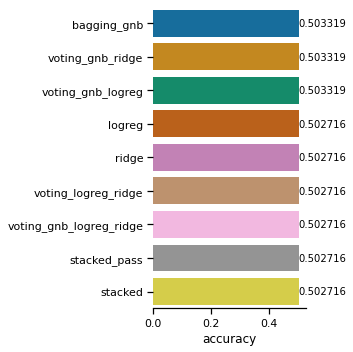

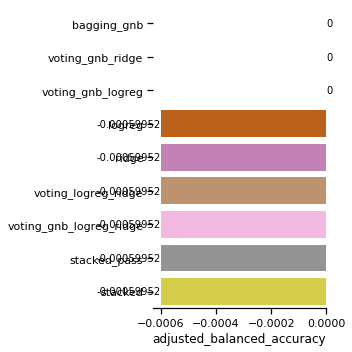

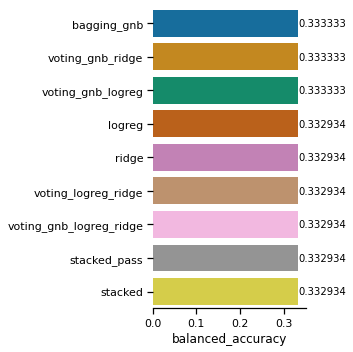

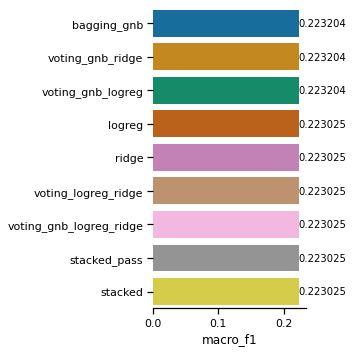

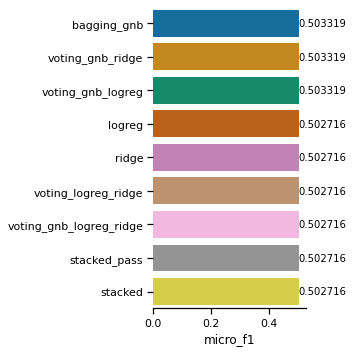

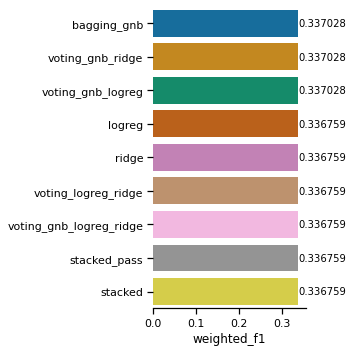

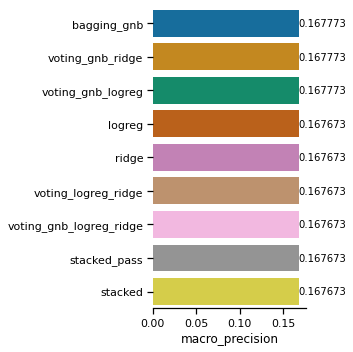

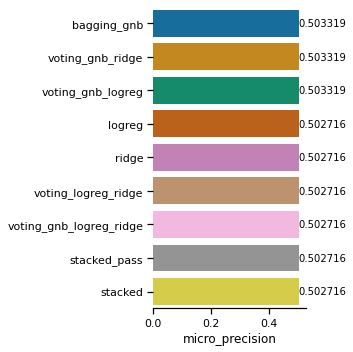

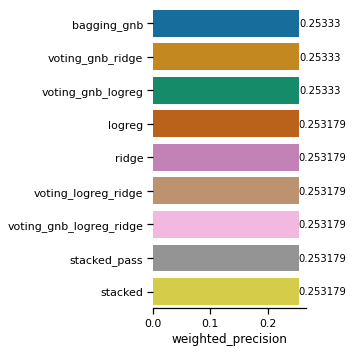

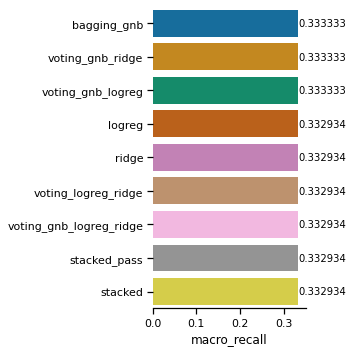

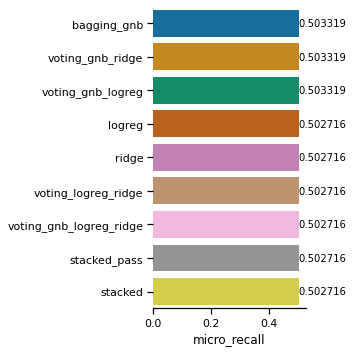

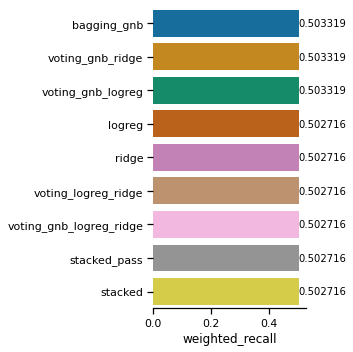

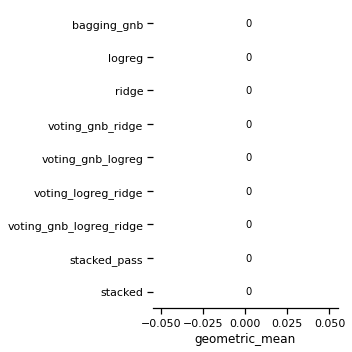

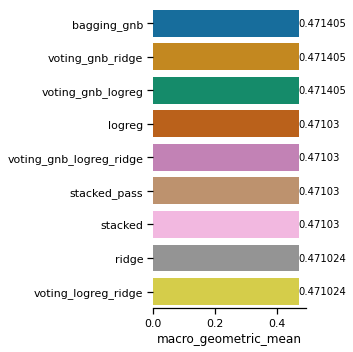

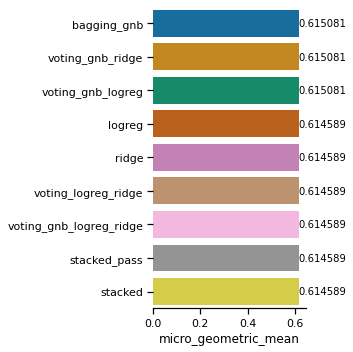

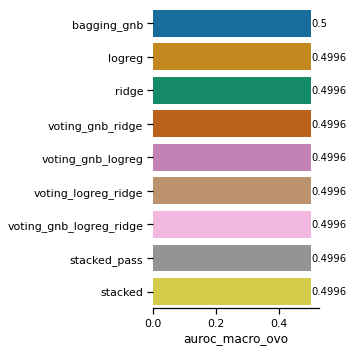

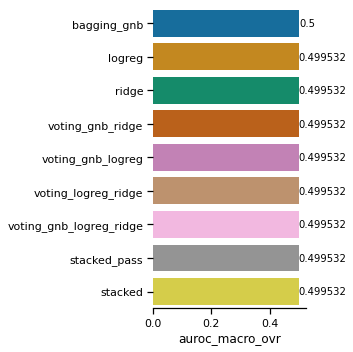

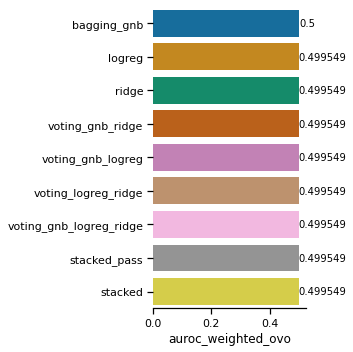

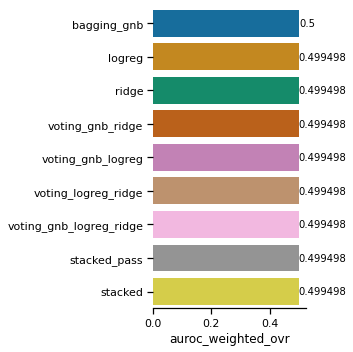

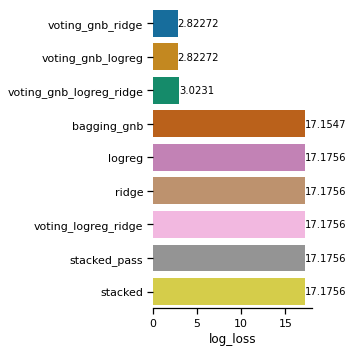

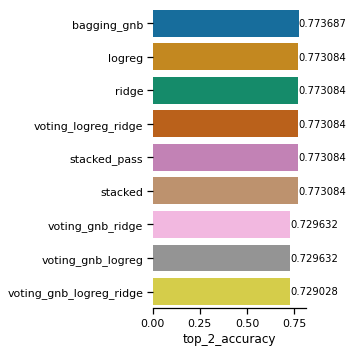

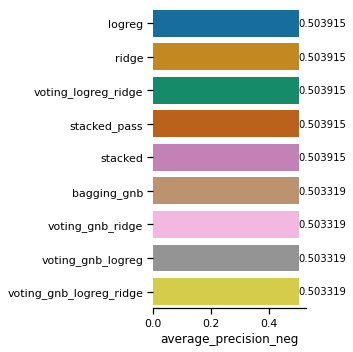

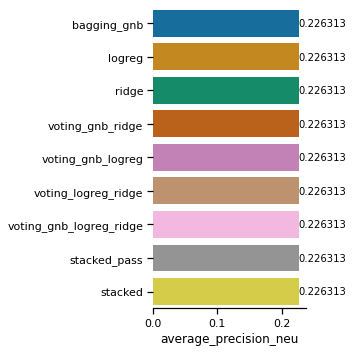

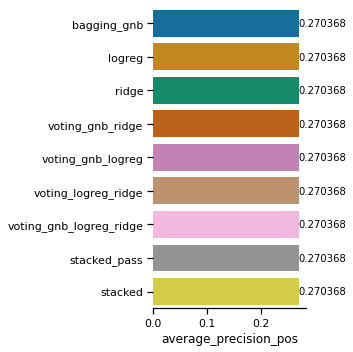

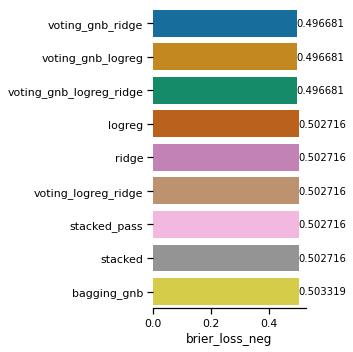

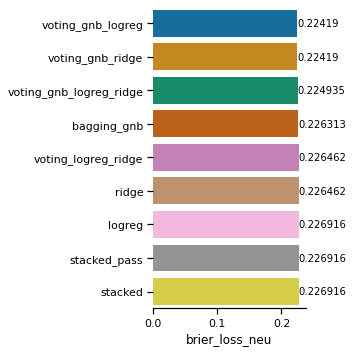

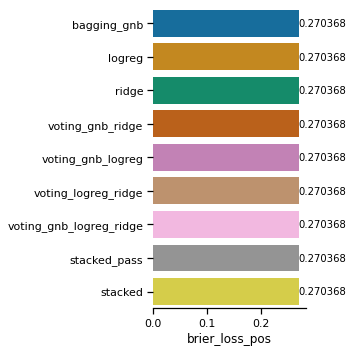

time: 11 s


In [9]:
# visualize
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    g = sns.catplot(
        x=metric,
        y="model",
        data=df,
        kind="bar",
        linewidth=0,
        palette="colorblind",
    )
    ax = plt.gca()
    _ = ax.bar_label(ax.containers[0])
    sns.despine(left=True, top=True, right=True)
    _ = plt.ylabel("")
    plt.tight_layout()
    plt.show()
    del df
    del g
    del ax
    _ = gc_collect()

## By speaker gender

In [10]:
for model in tqdm(MODELS):
    results = score_model(
        model, "m_speaker", data.loc[labels.speaker_gender == "m", :], results
    )
for model in tqdm(MODELS):
    results = score_model(
        model, "f_speaker", data.loc[labels.speaker_gender == "f", :], results
    )

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

time: 13.5 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


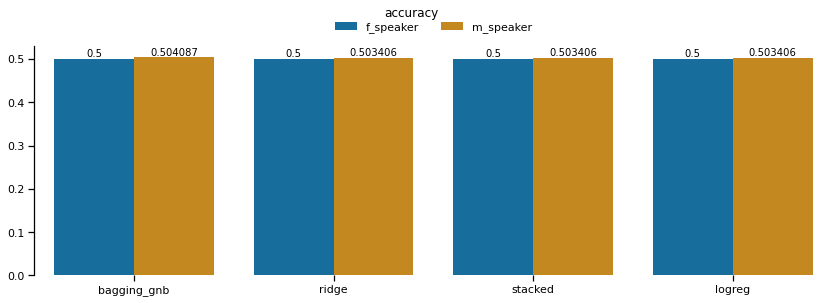

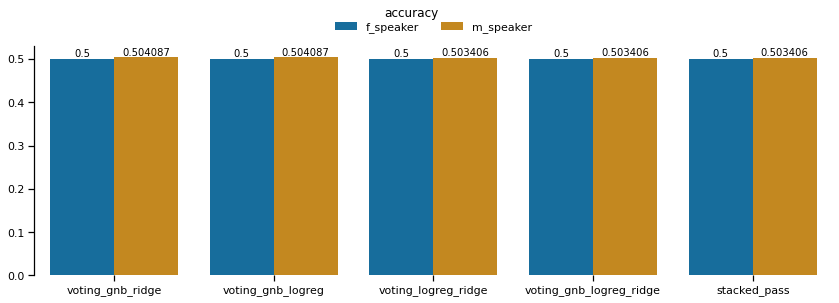

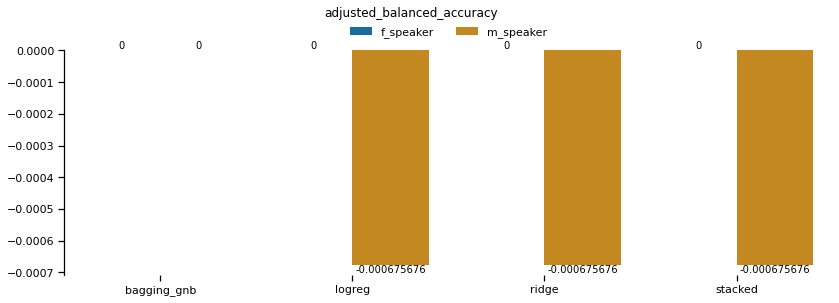

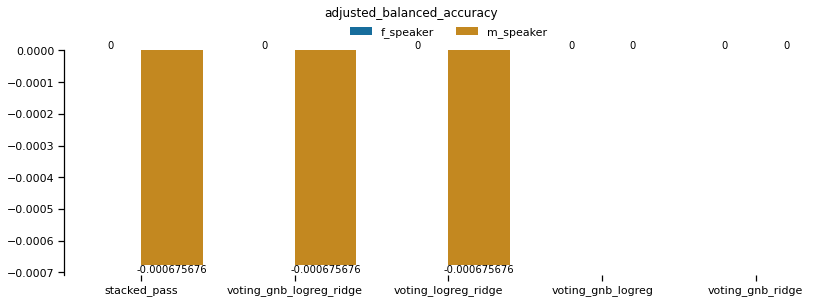

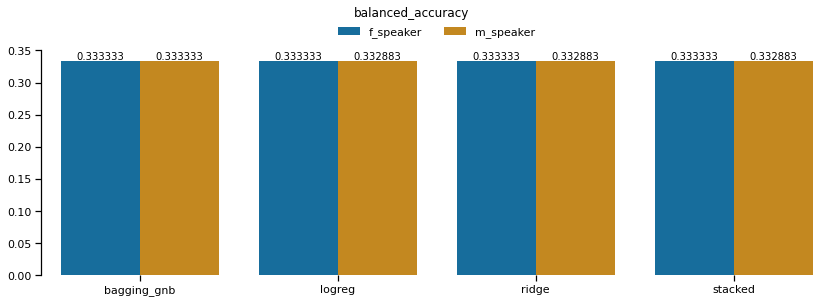

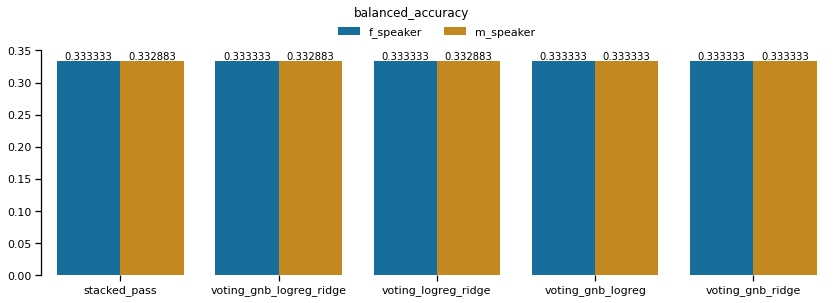

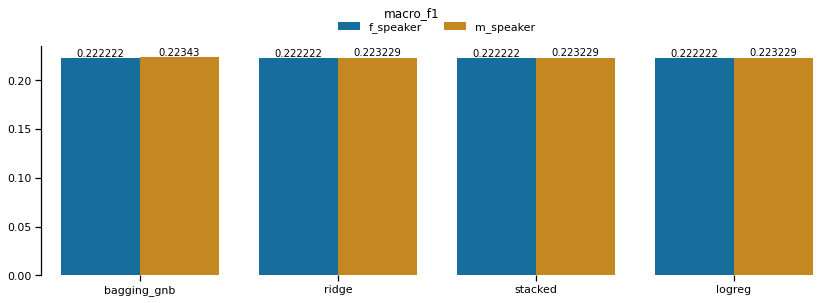

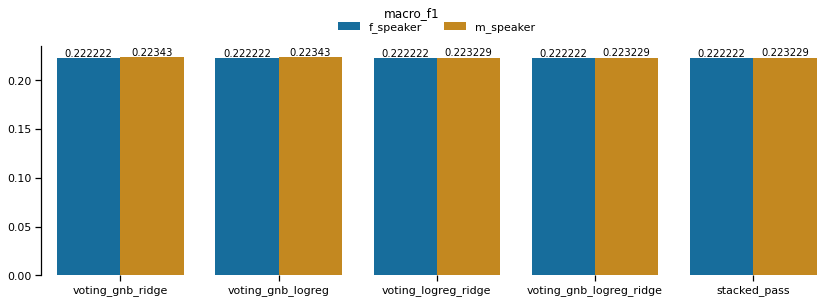

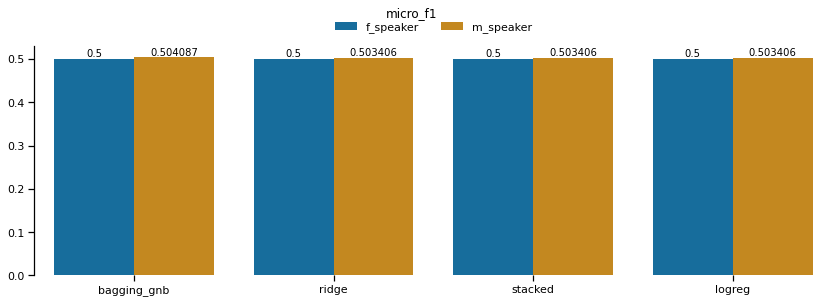

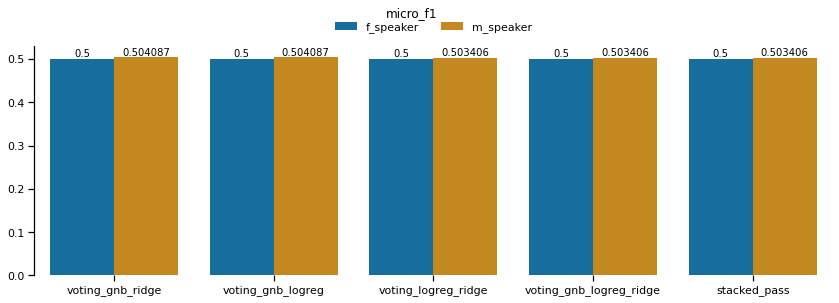

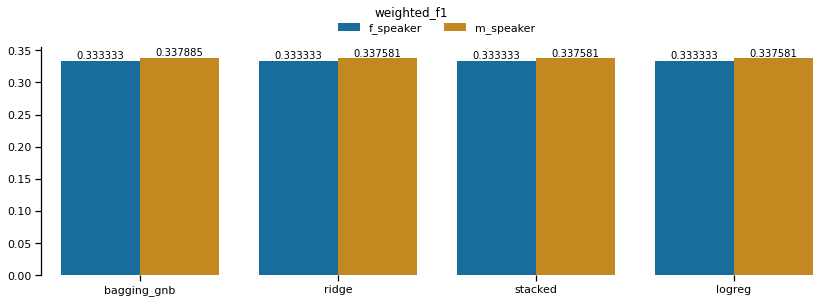

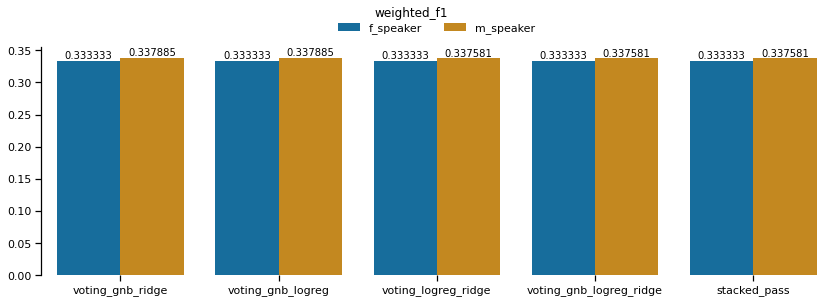

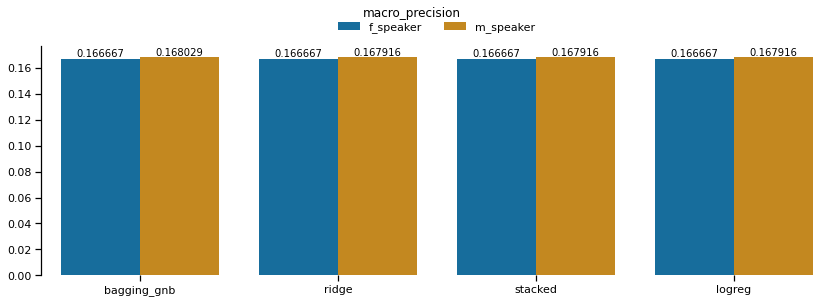

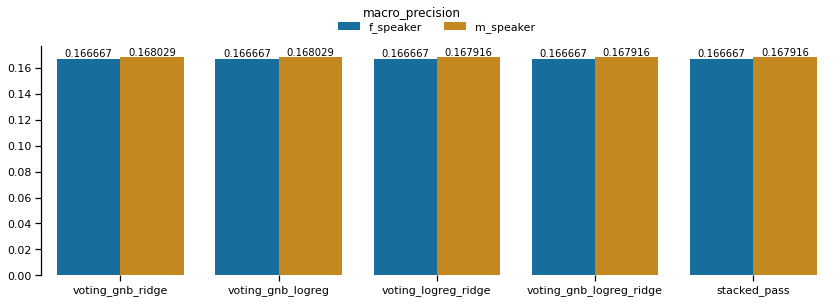

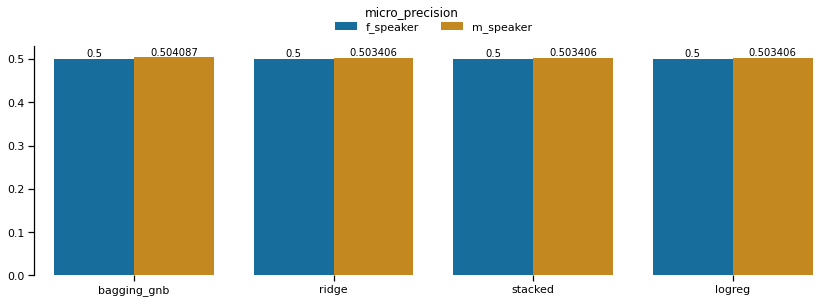

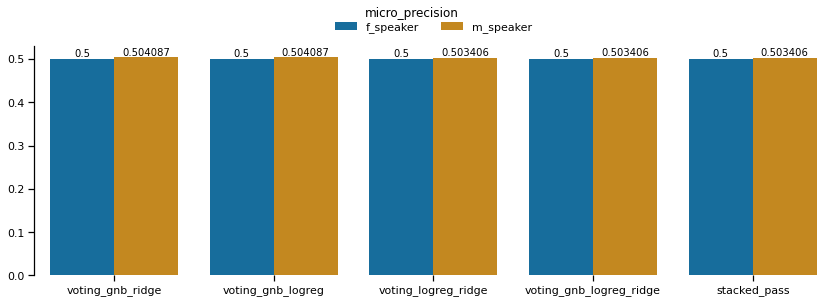

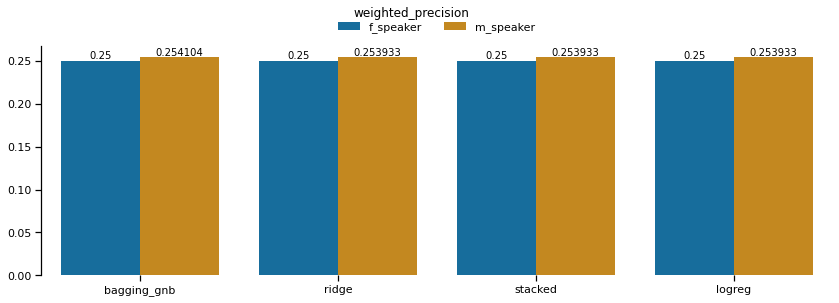

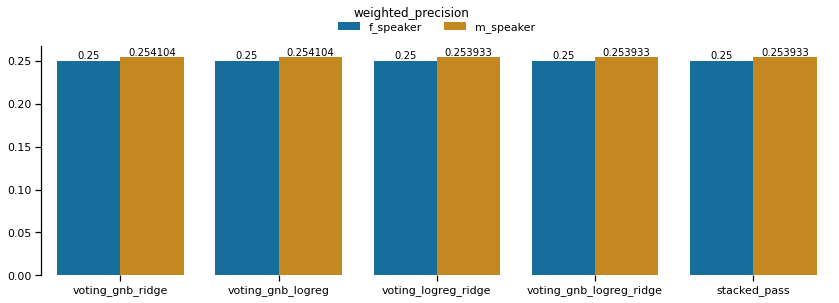

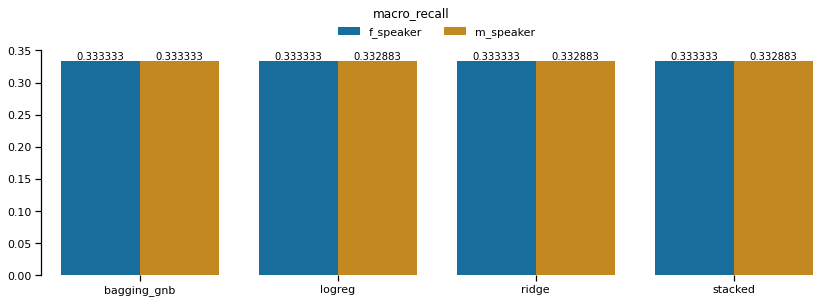

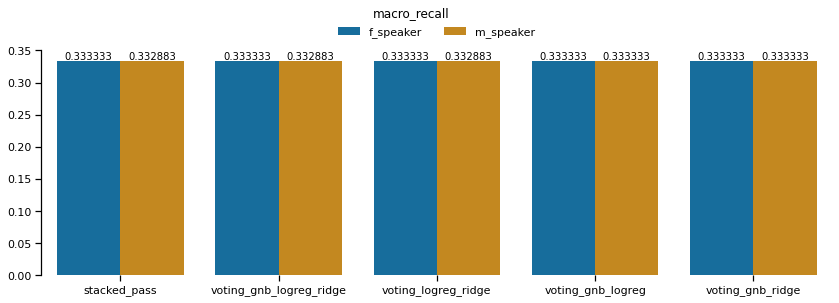

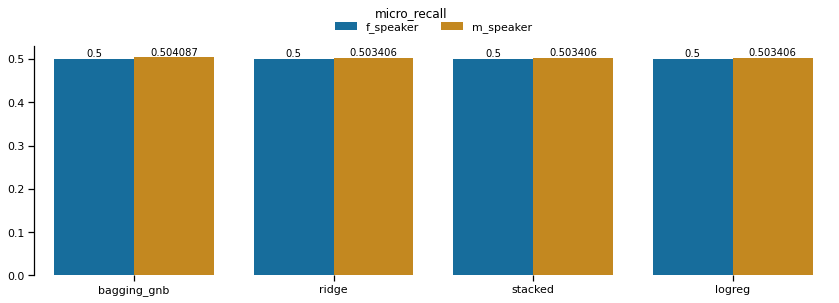

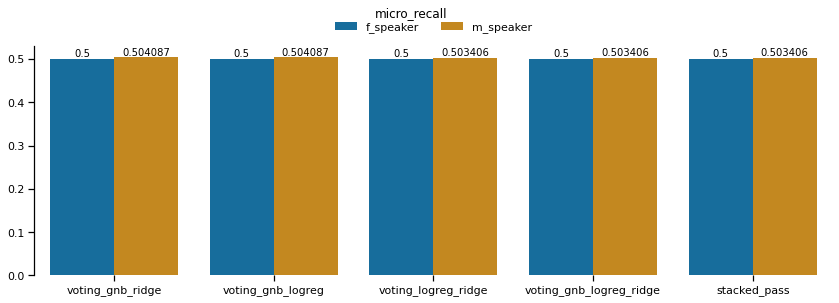

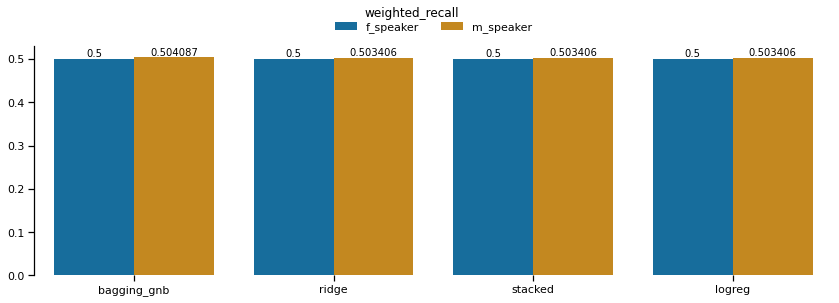

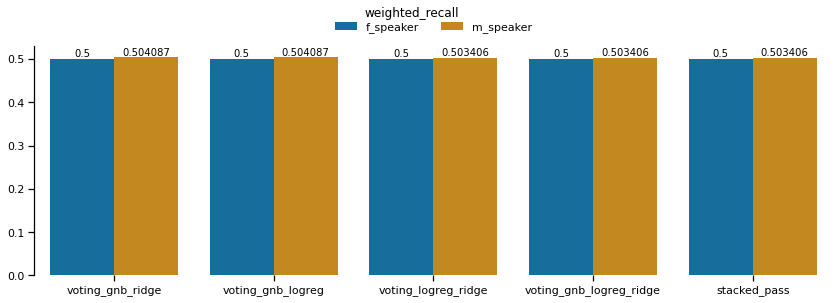

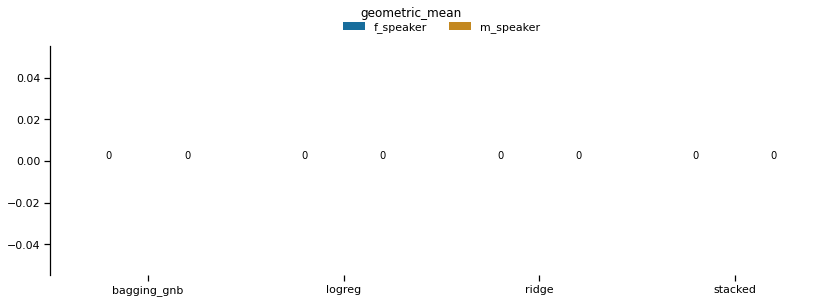

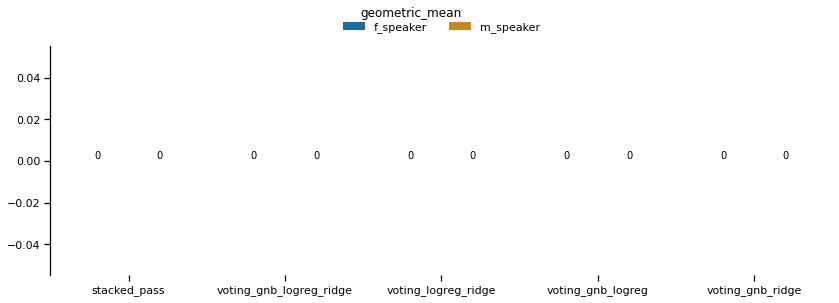

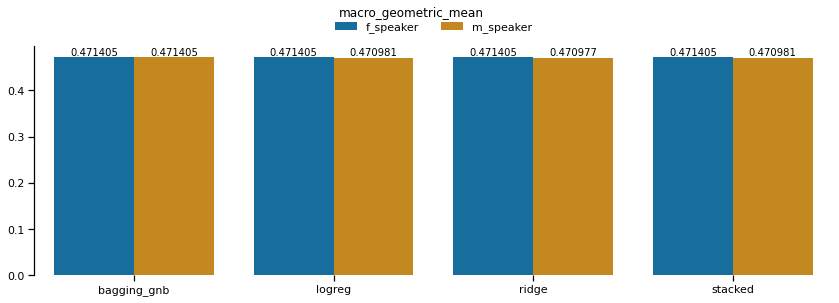

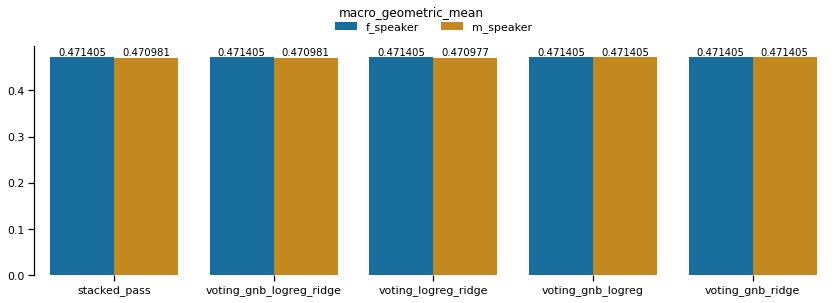

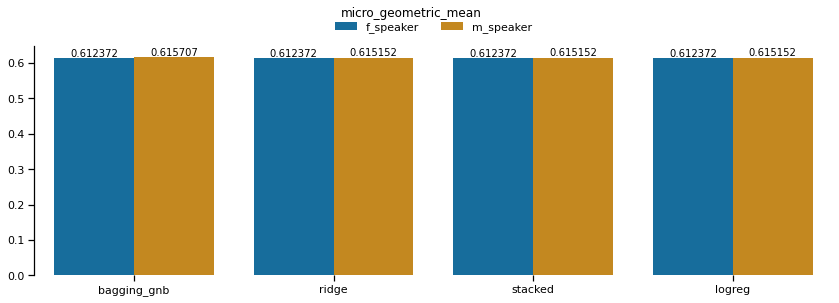

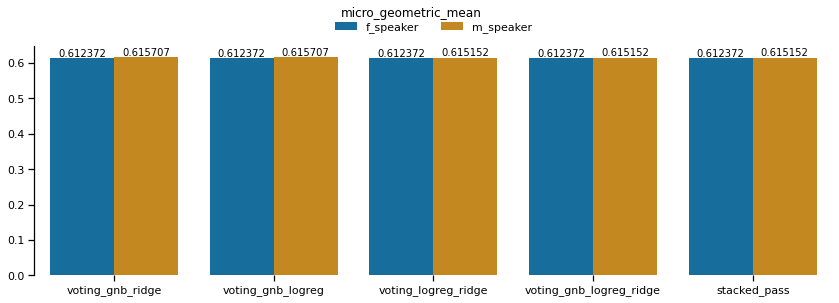

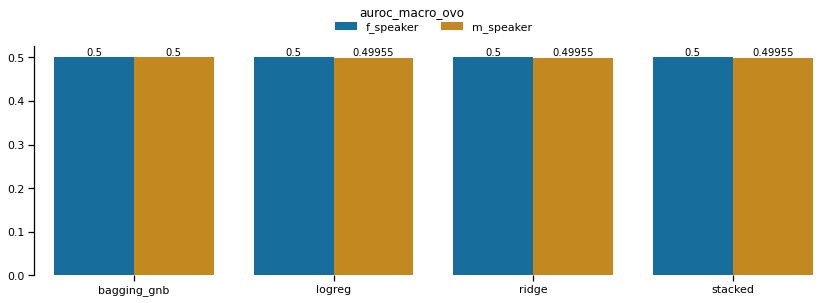

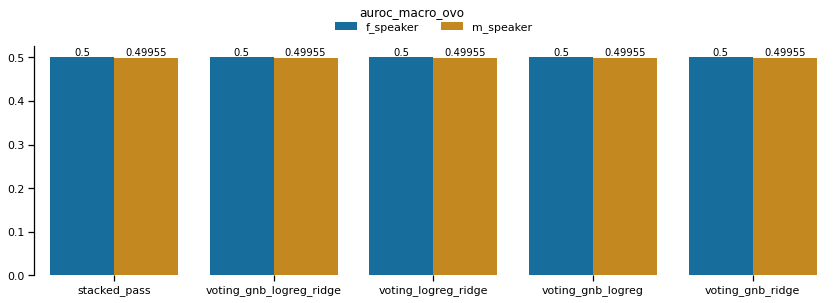

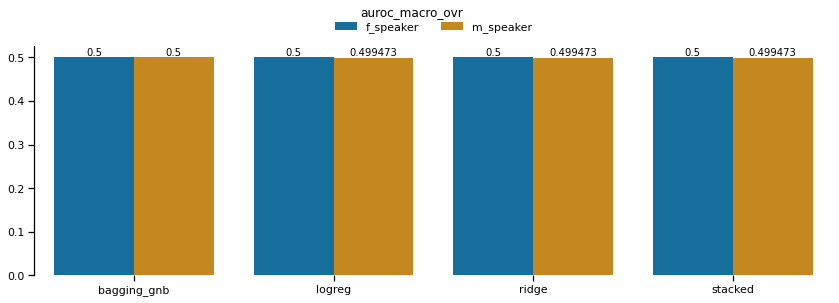

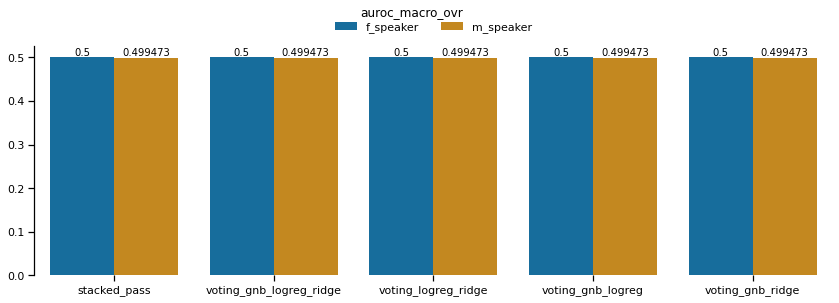

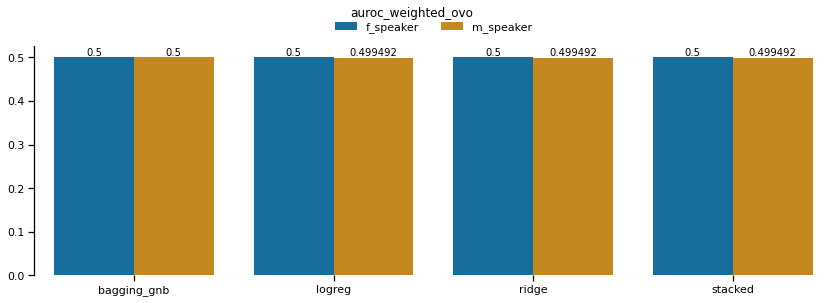

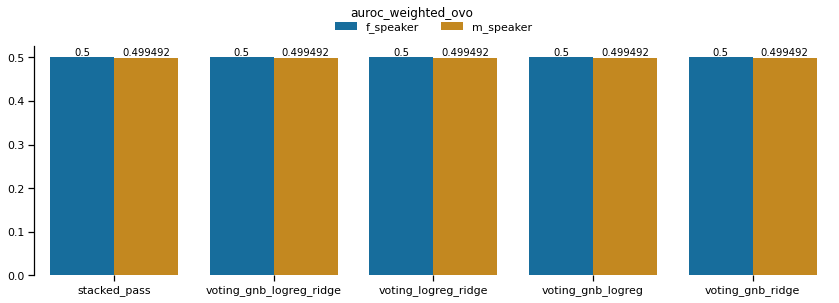

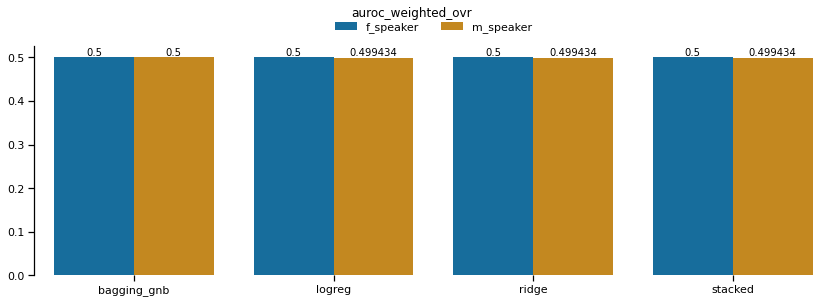

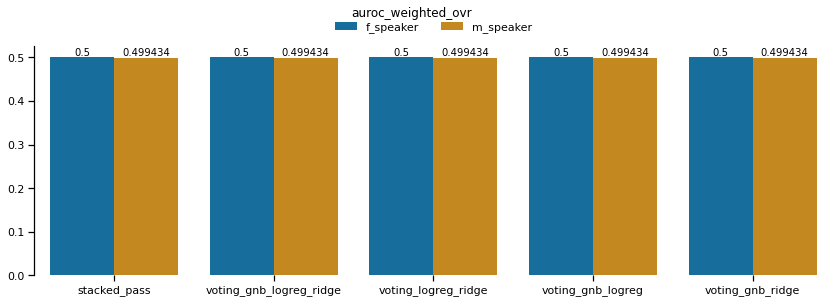

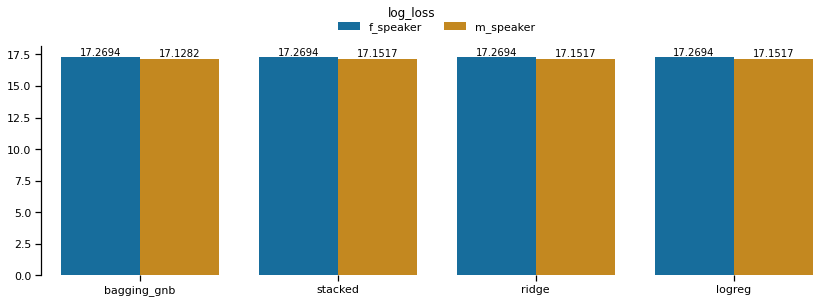

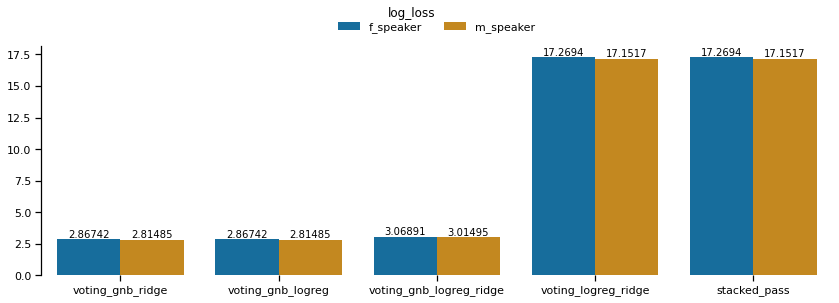

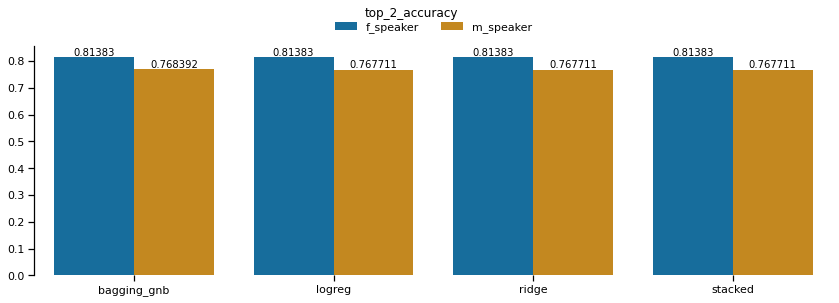

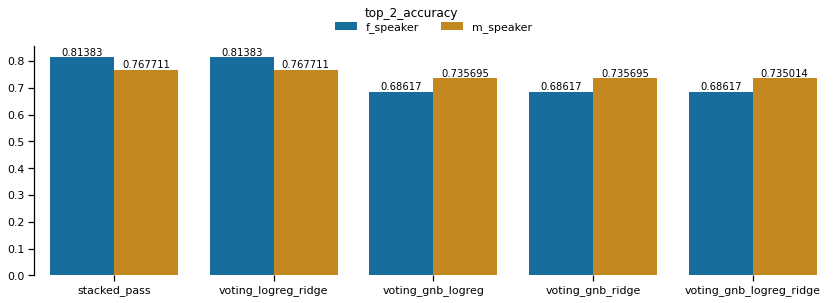

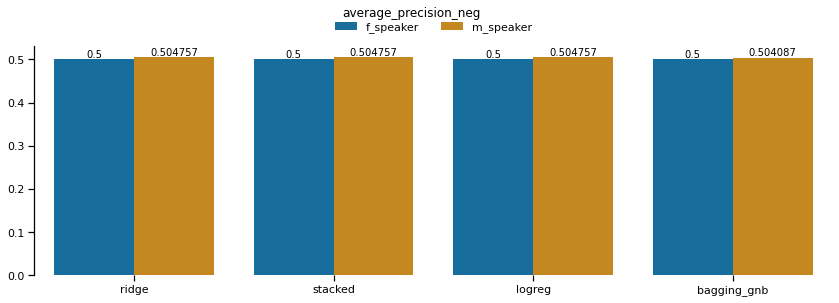

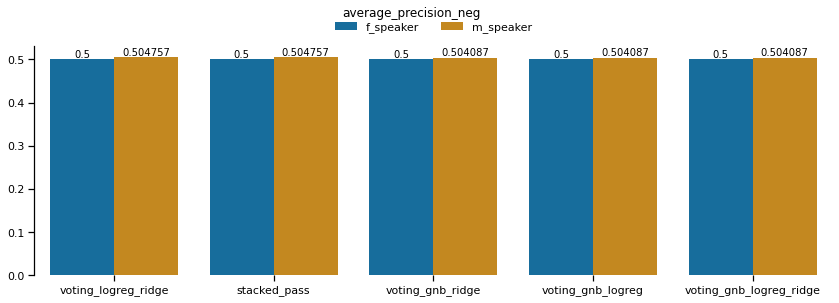

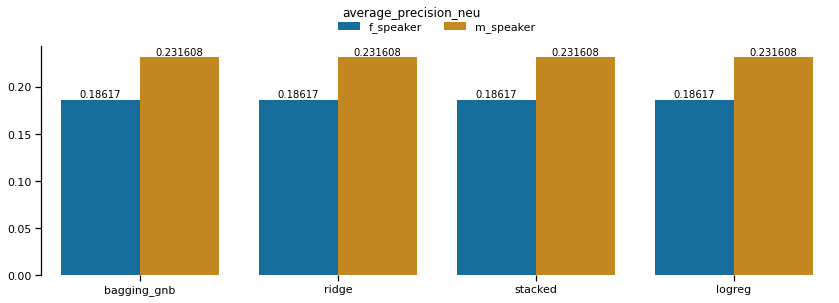

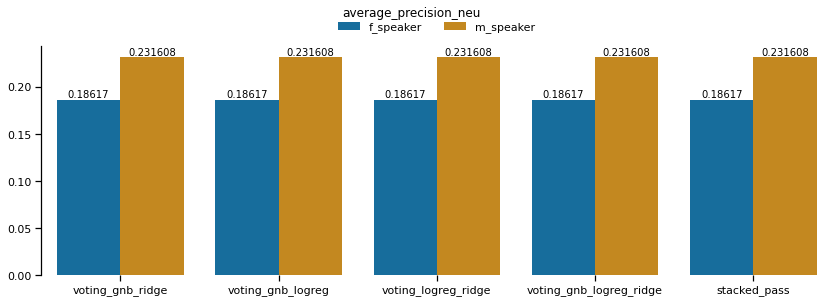

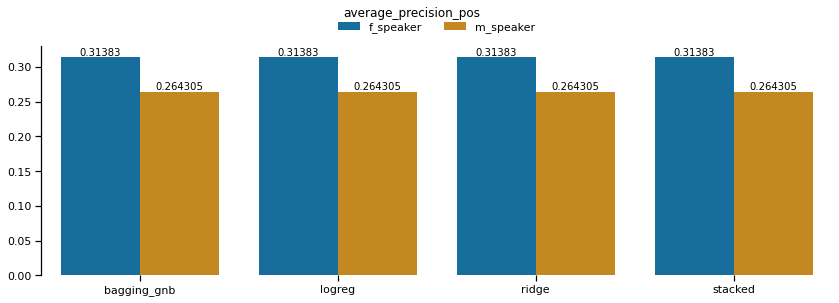

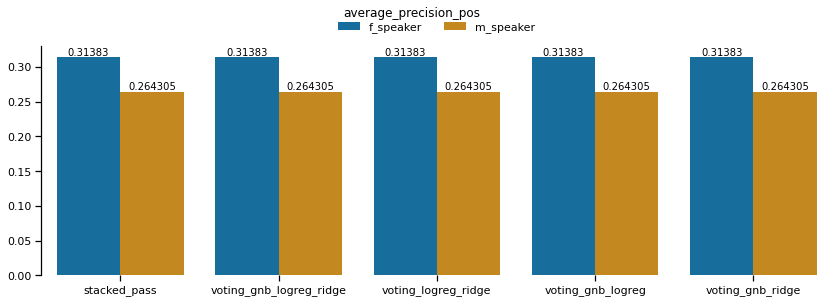

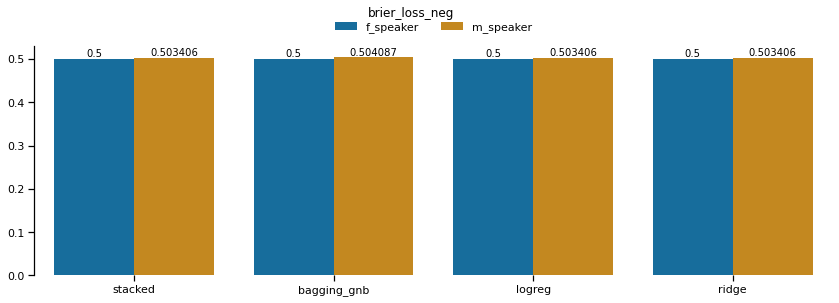

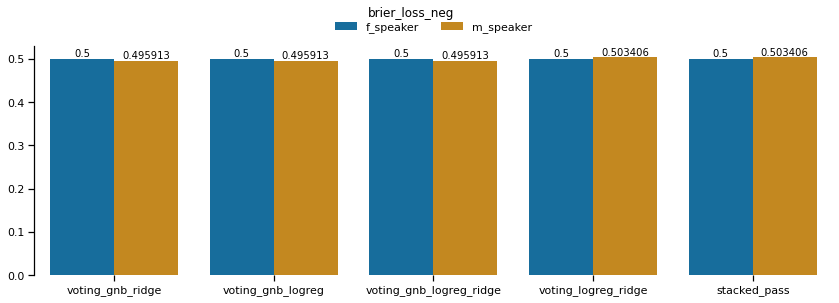

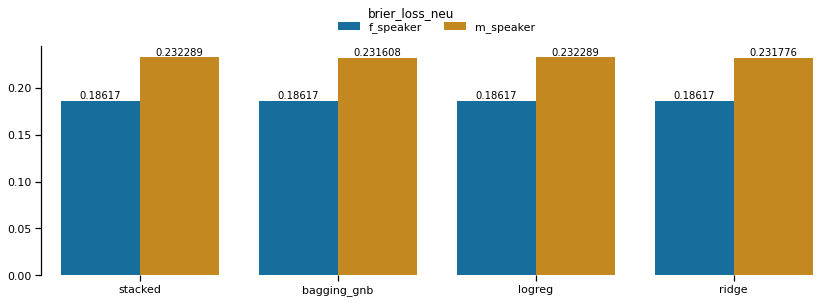

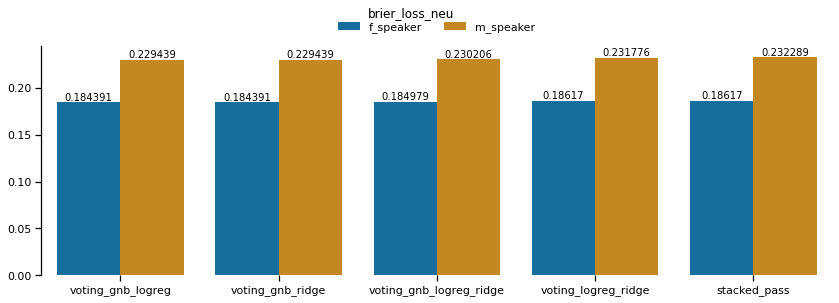

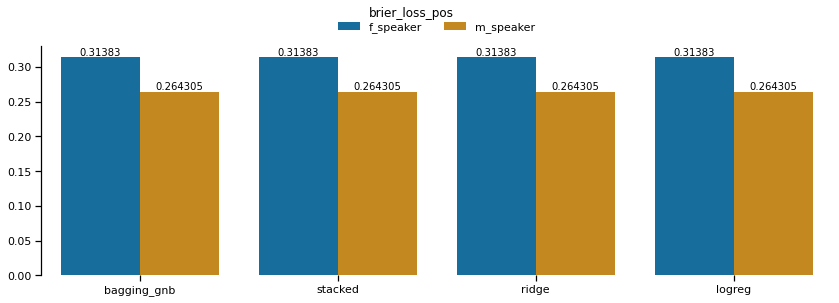

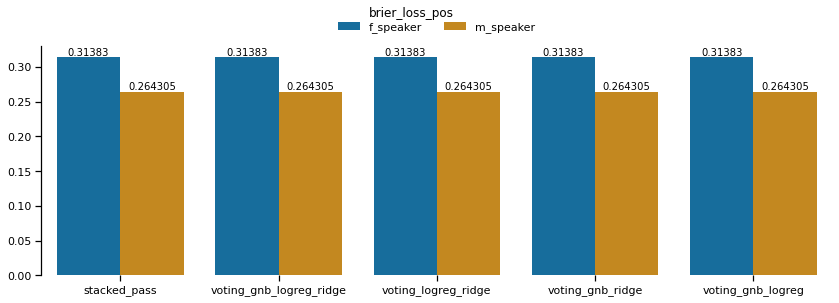

time: 17.1 s


In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df.score_set.isin({"f_speaker", "m_speaker"}), :]
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    models = np.unique(df.model)
    df1 = df.loc[df.model.isin(models[: (_ := len(models) // 2)]), :]
    df2 = df.loc[df.model.isin(models[_:]), :]
    g = sns.catplot(
        x="model",
        y=metric,
        data=df1,
        kind="bar",
        hue="score_set",
        hue_order=["f_speaker", "m_speaker"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=3,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    _ = plt.legend(
        bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2, frameon=False
    )
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()

    g = sns.catplot(
        x="model",
        y=metric,
        data=df2,
        kind="bar",
        hue="score_set",
        hue_order=["f_speaker", "m_speaker"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=3,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    _ = plt.legend(
        bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2, frameon=False
    )
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()

_ = gc_collect()

In contrast to the first prototypes, it looks like the new prototypes are better with male speakers by nearly all metrics.

## By language

This is roughly equivalent to the data source of the holdout sets. Note that x4nth055_SER_custom contains one sample in English, which is omitted in this section's analysis.

In [12]:
for model in tqdm(MODELS):
    results = score_model(model, "arb", data.loc[labels.lang1 == "arb", :], results)
for model in tqdm(MODELS):
    results = score_model(model, "deu", data.loc[labels.lang1 == "deu", :], results)
for model in tqdm(MODELS):
    results = score_model(model, "kor", data.loc[labels.lang1 == "kor", :], results)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/27 [00:00<?, ?it/s]

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/27 [00:00<?, ?it/s]

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/27 [00:00<?, ?it/s]

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

time: 20.1 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The Arabic dataset only has two emotions (happy and neutral).

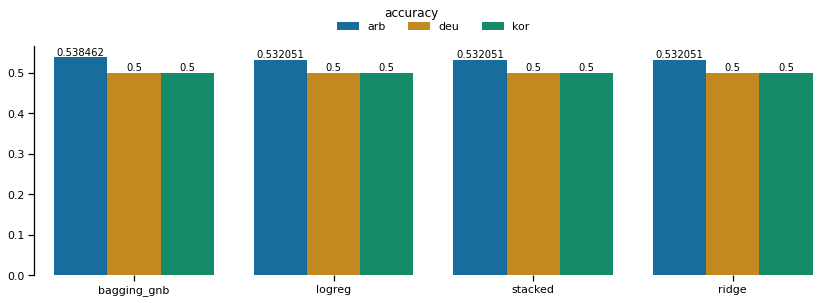

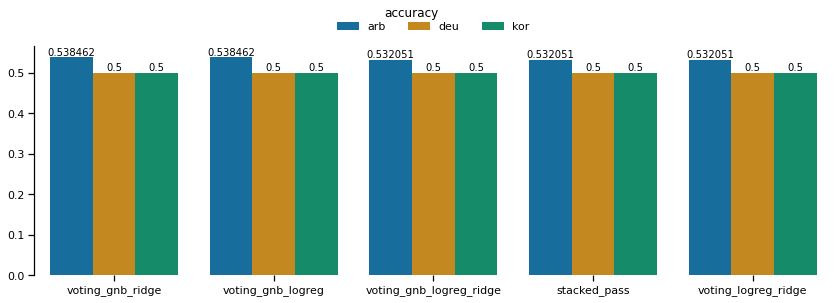

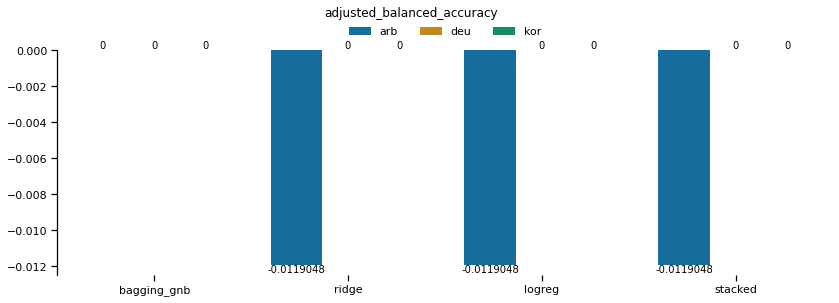

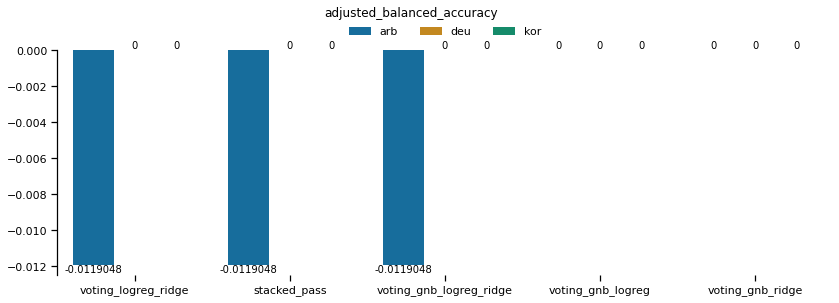

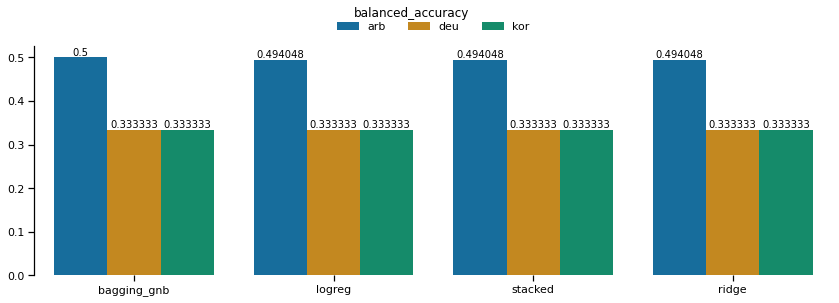

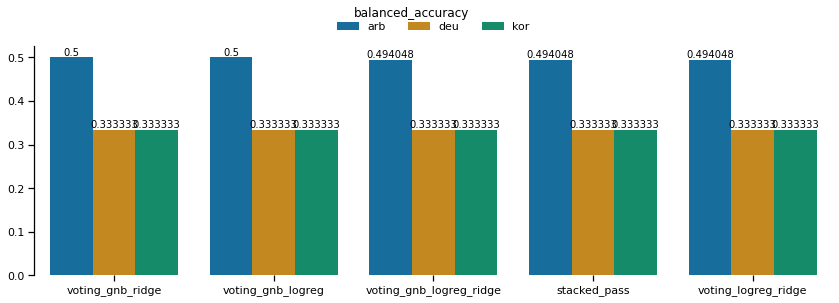

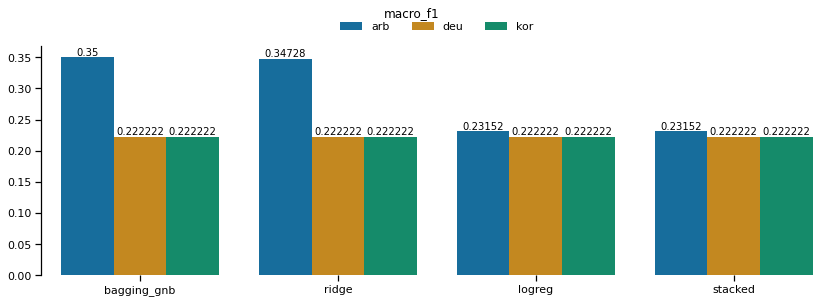

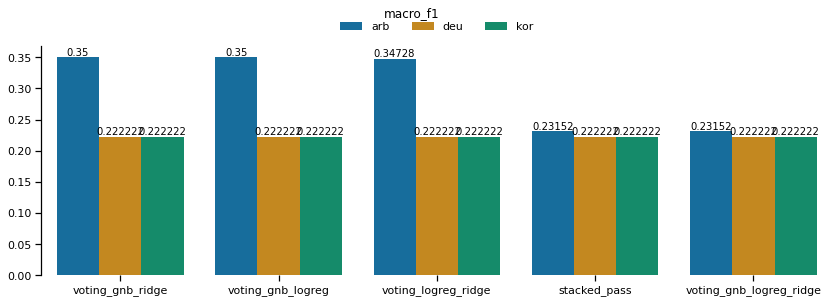

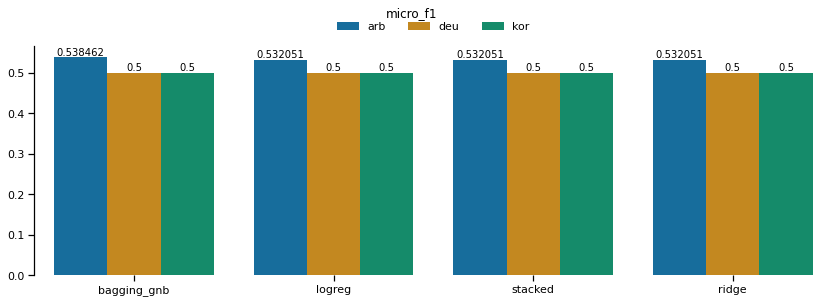

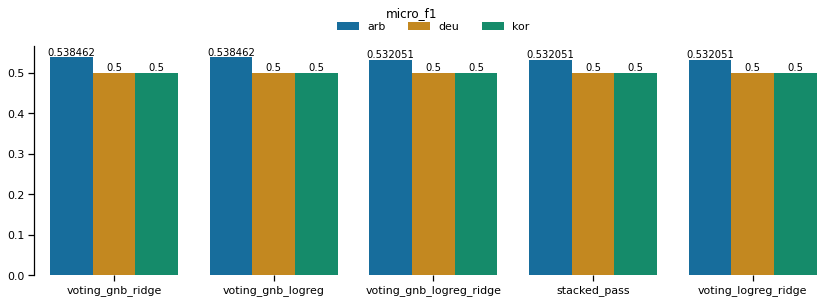

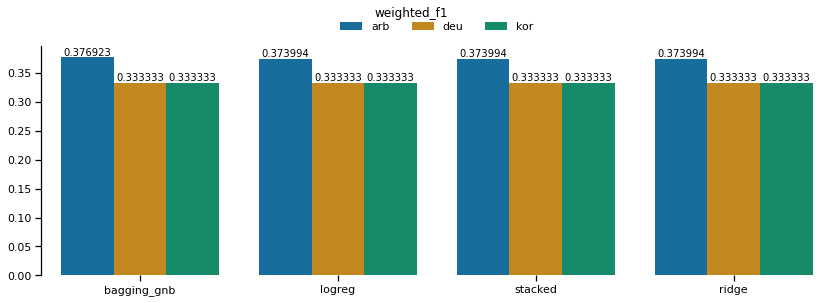

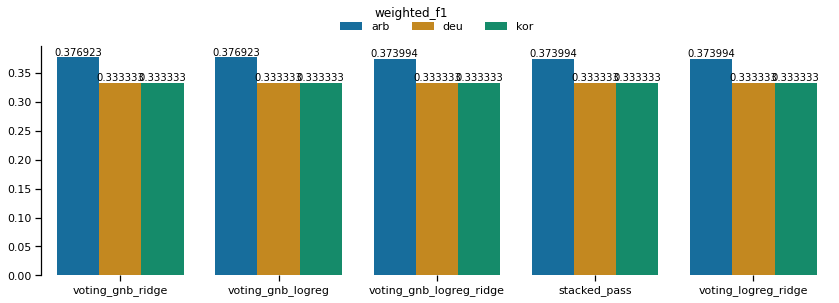

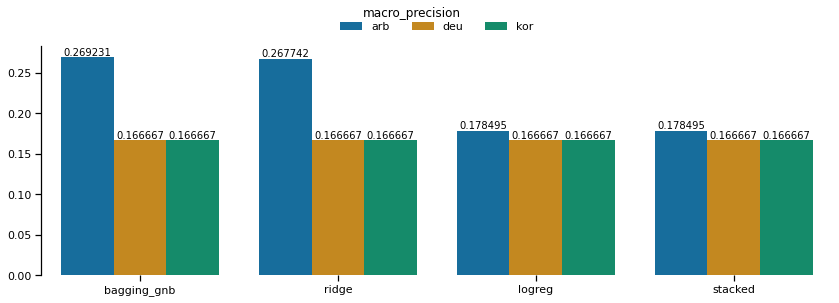

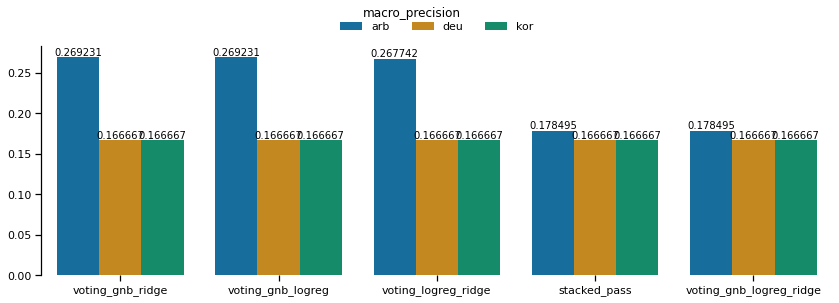

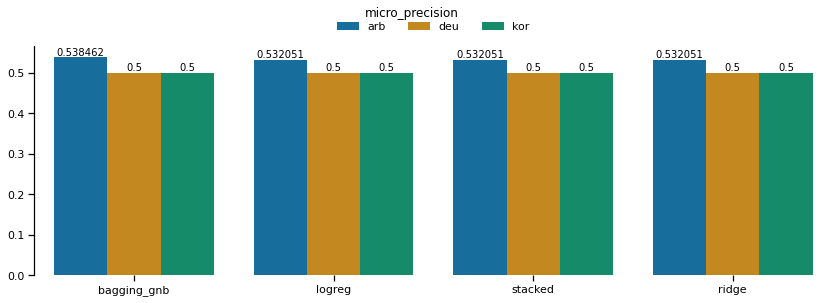

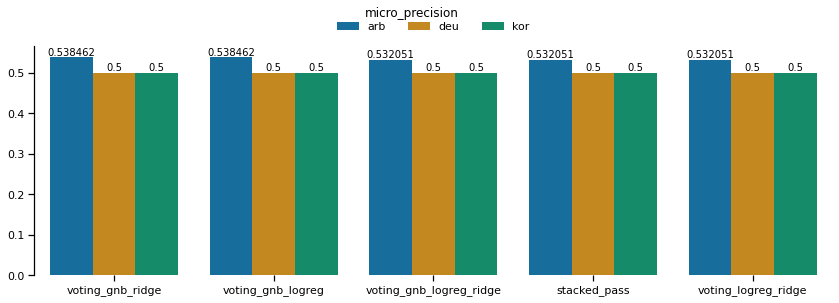

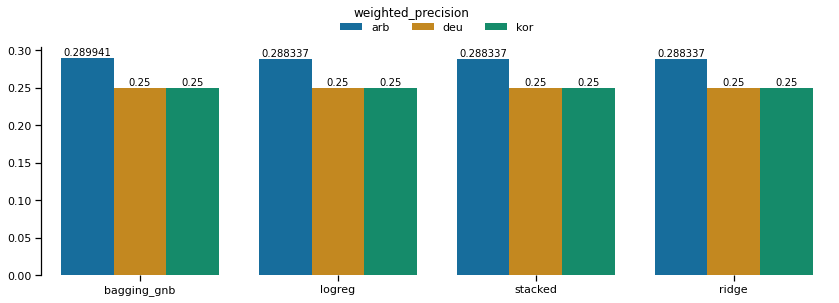

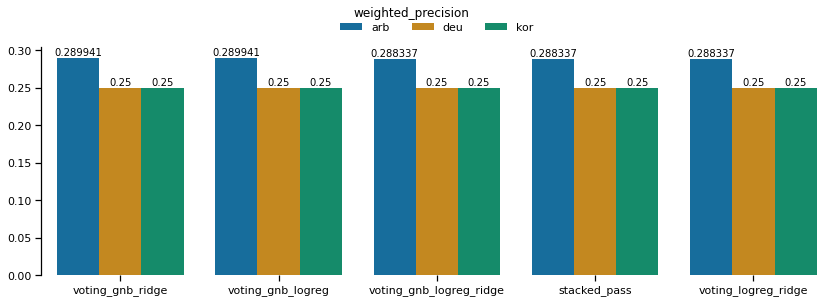

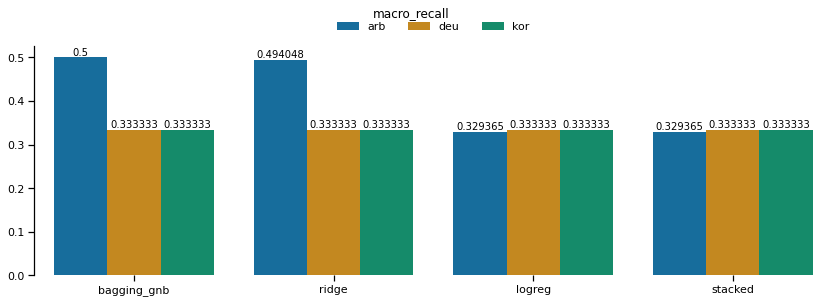

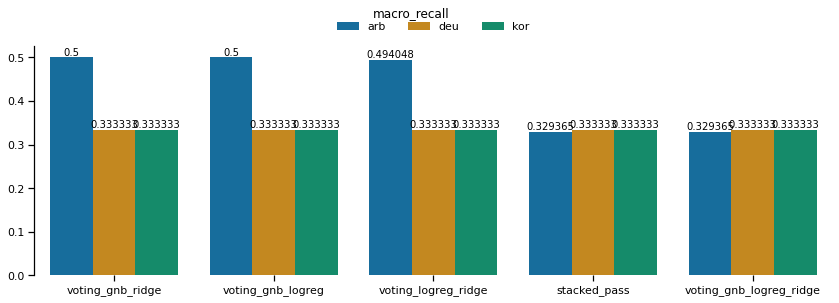

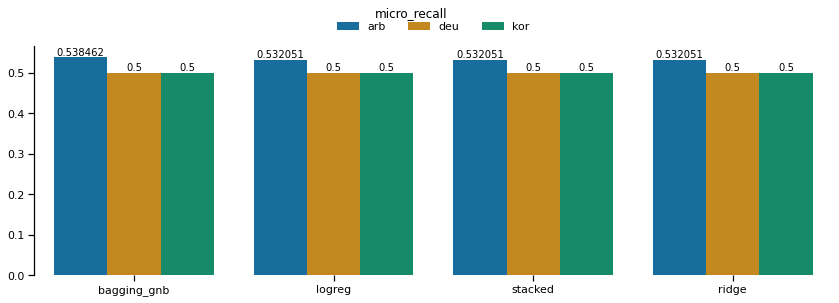

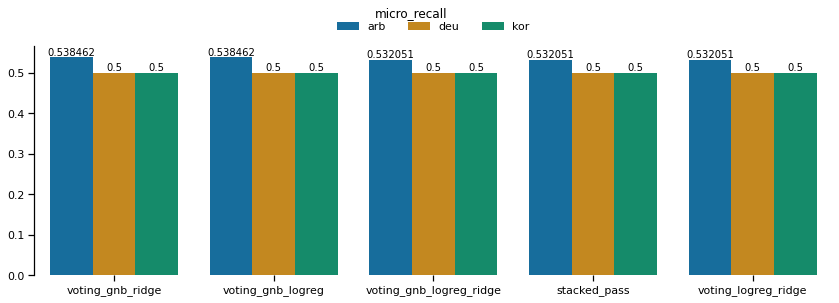

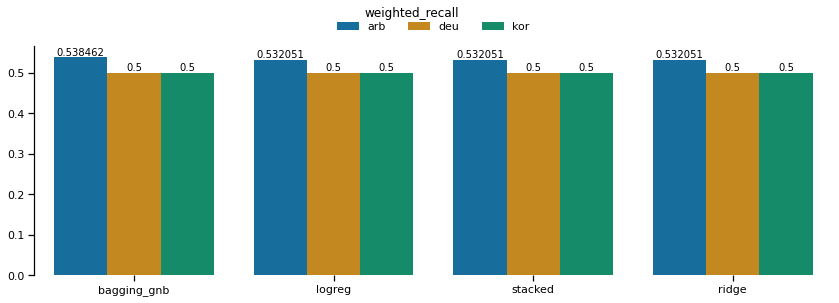

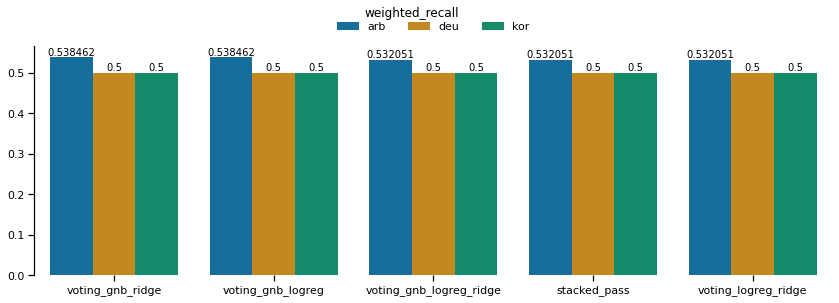

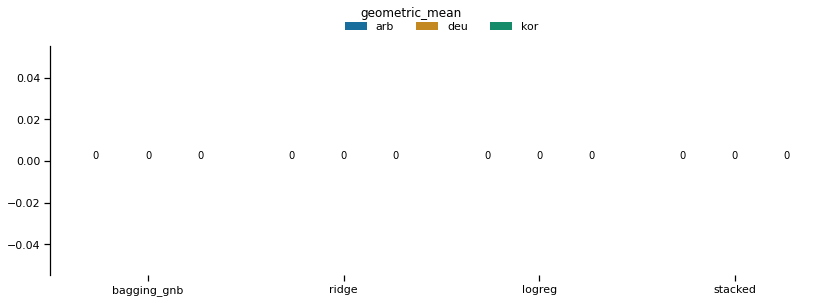

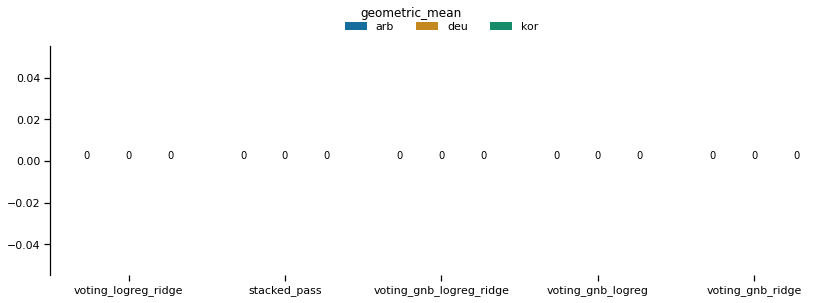

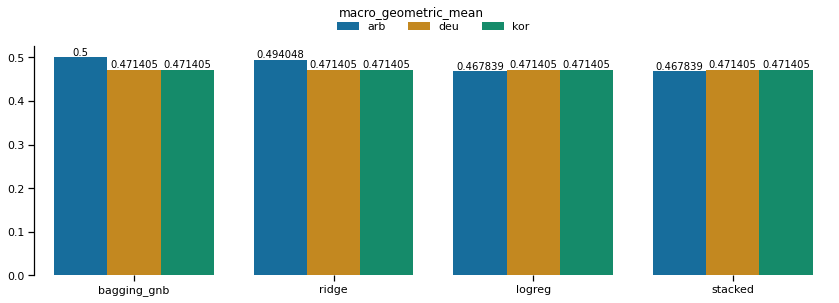

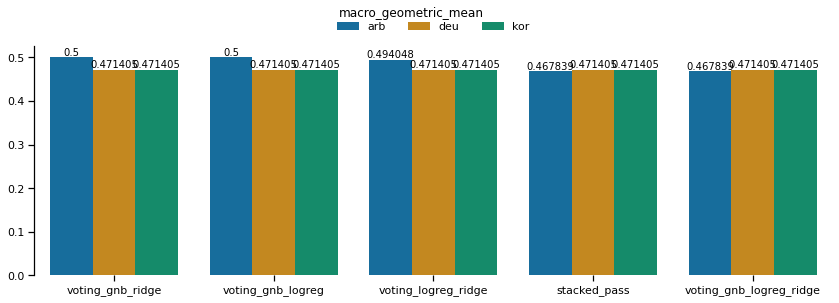

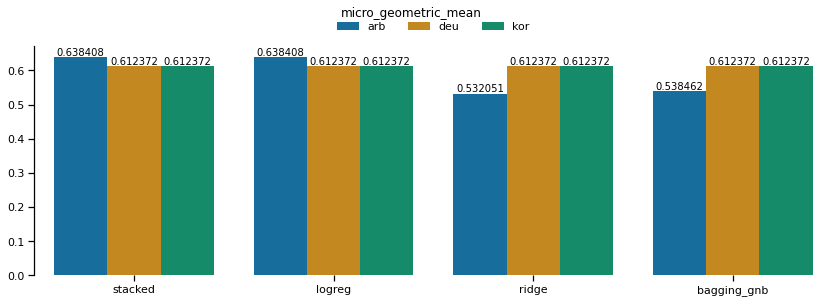

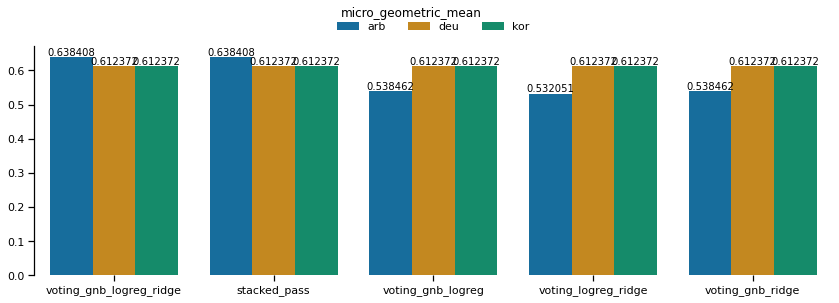

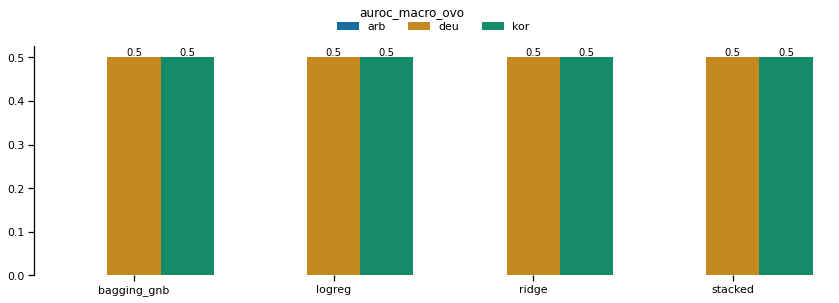

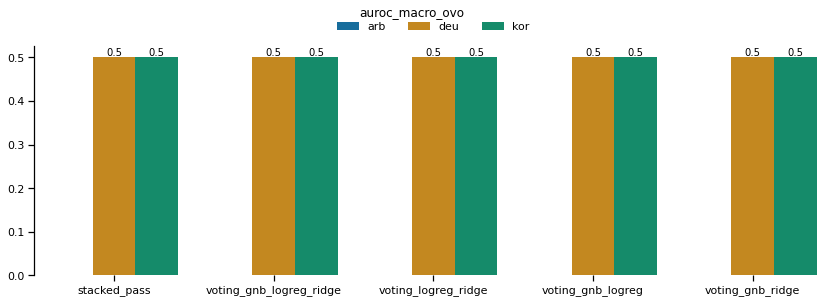

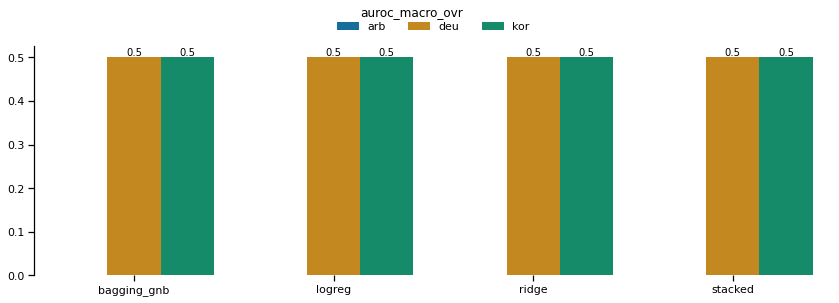

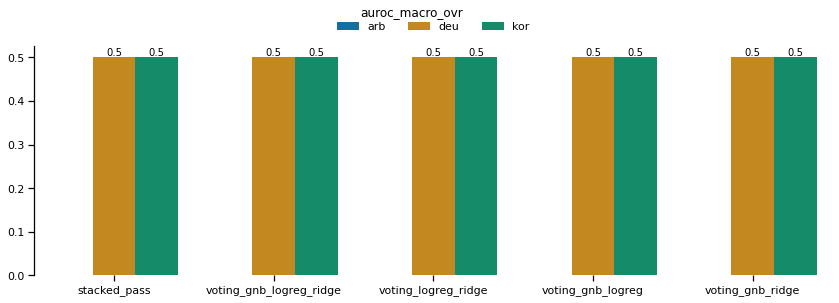

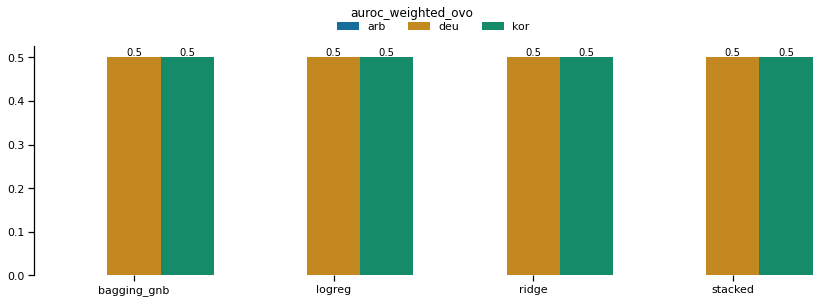

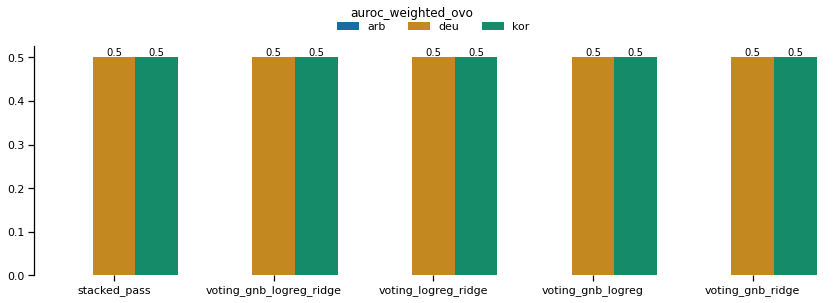

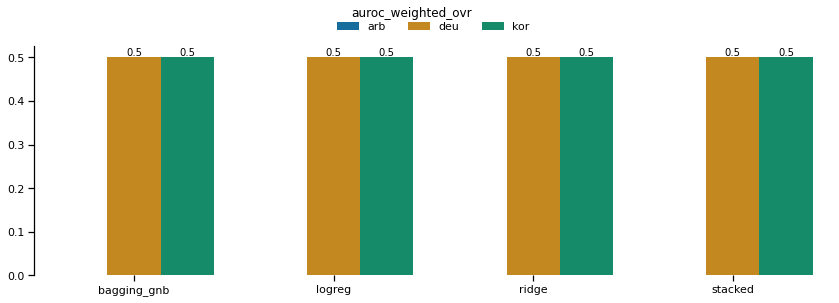

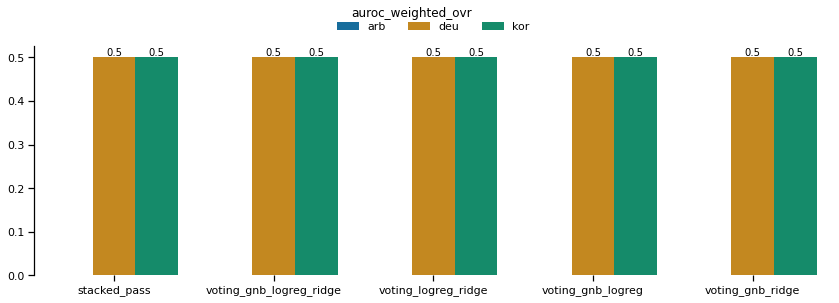

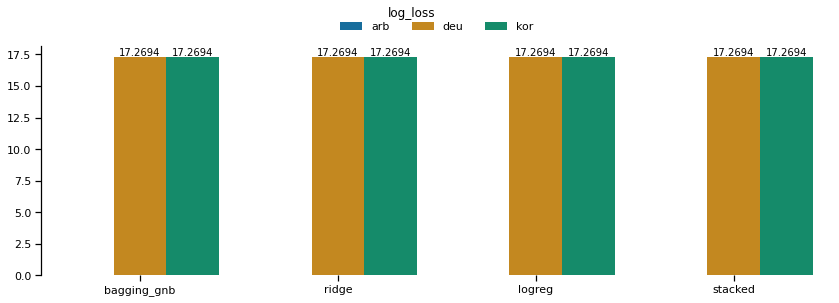

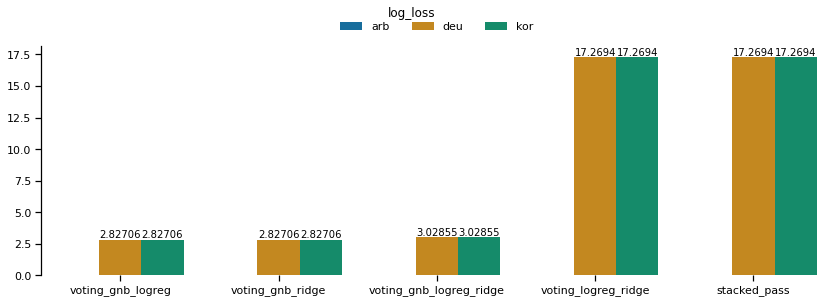

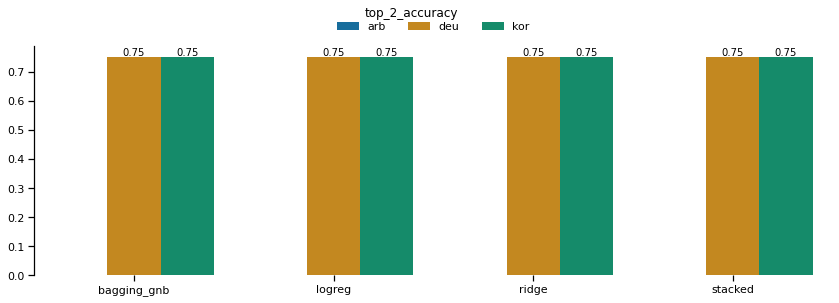

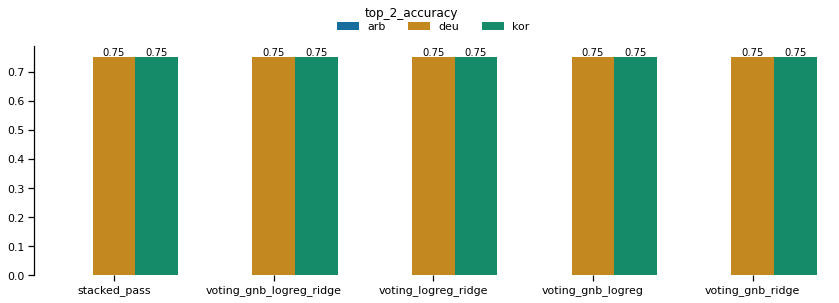

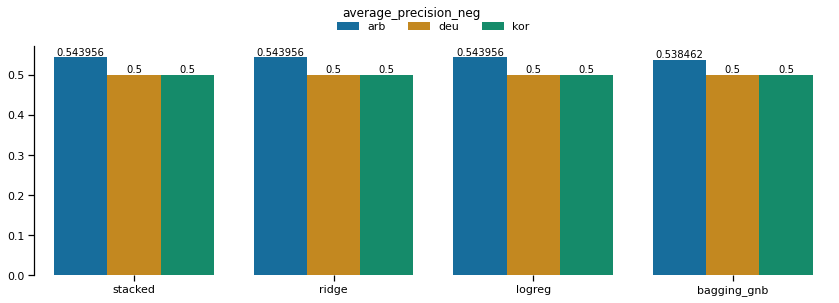

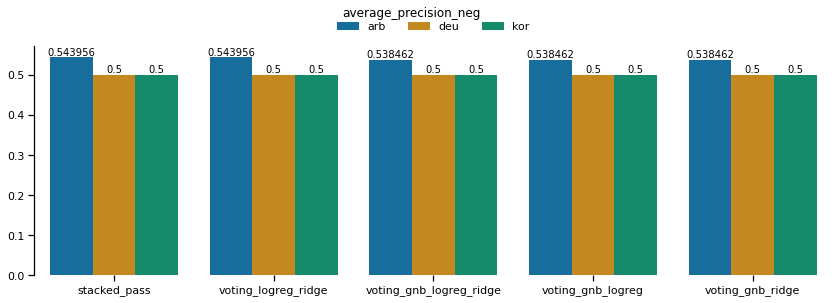

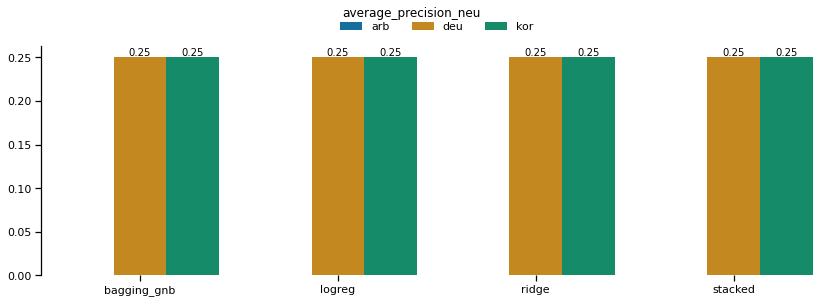

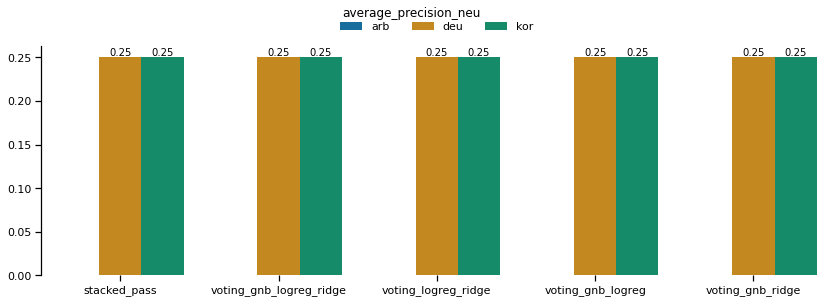

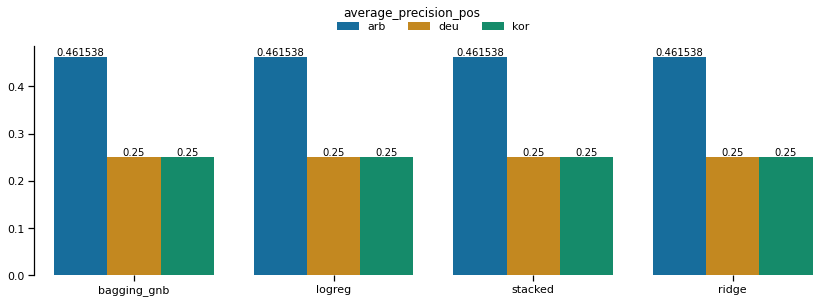

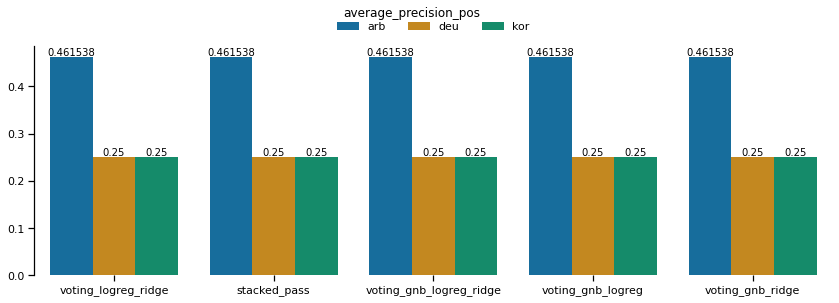

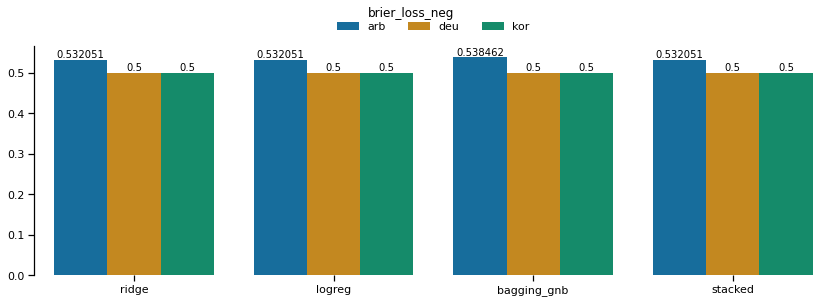

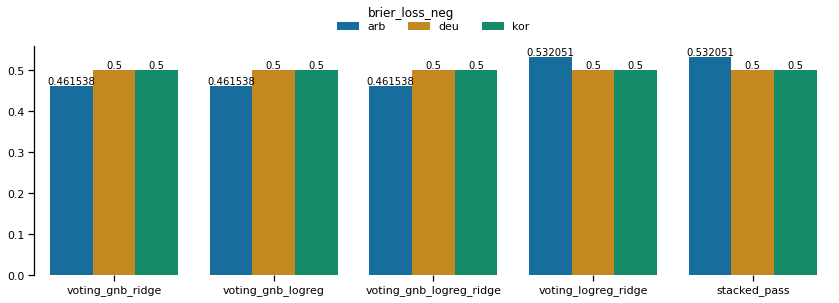

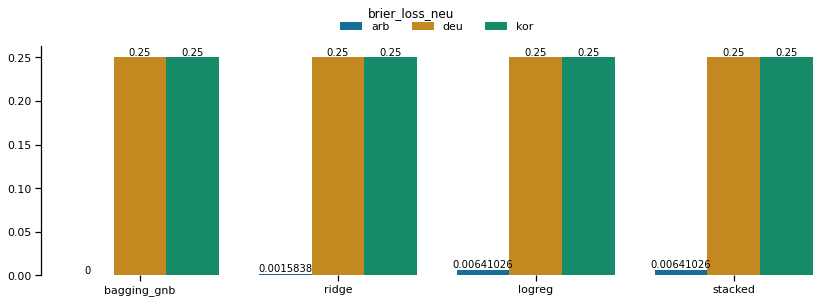

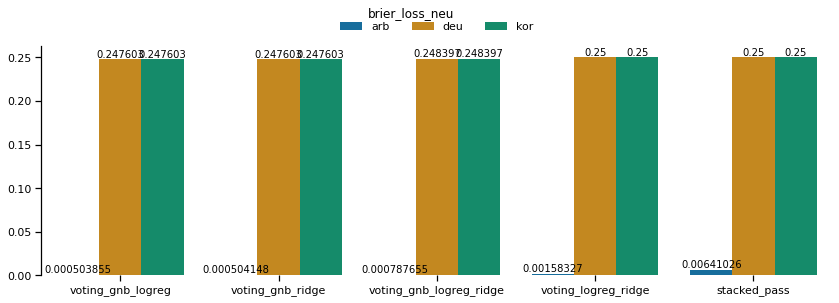

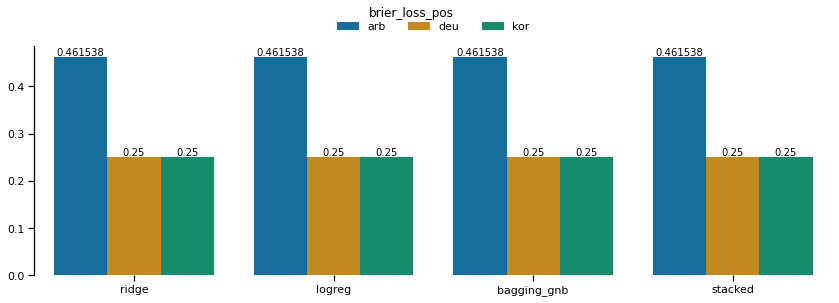

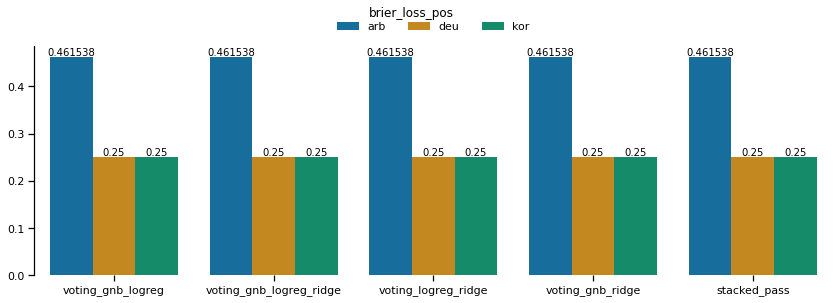

time: 20.1 s


In [13]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df.score_set.isin({"arb", "deu", "kor"}), :]
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    models = np.unique(df.model)
    df1 = df.loc[df.model.isin(models[: (_ := len(models) // 2)]), :]
    df2 = df.loc[df.model.isin(models[_:]), :]
    g = sns.catplot(
        x="model",
        y=metric,
        data=df1,
        kind="bar",
        hue="score_set",
        hue_order=["arb", "deu", "kor"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=3,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=3, frameon=False)
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()

    g = sns.catplot(
        x="model",
        y=metric,
        data=df2,
        kind="bar",
        hue="score_set",
        hue_order=["arb", "deu", "kor"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=3,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=3, frameon=False)
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()

    del df
    del df1
    del df2
    del g
    del ax
    _ = gc_collect()

## By valence (OvR)

In [14]:
for valence in ("neg", "neu", "pos"):
    for model in tqdm(MODELS):
        results["model"].append(model)
        results["score_set"].append(valence)
        _ = model
        df = data.loc[:, GNB_FEATURES] if model == "bagging_GNB" else data
        model = load_model(model)
        y_pred = model.predict(df)
        y_prob = model.predict_proba(df)
        dump(y_prob, f"{OUT_FOLDER}/predictions/{_}_{valence}.pkl")
        del df
        del model
        _ = gc_collect()
        for metric, scorer in tqdm(METRICS.items()):
            if "average_precision" in metric or "brier_score" in metric:
                if metric[-3:] != valence:
                    results[metric].append(np.nan)
                    continue
            results[metric].append(
                binary_scorer(scorer, valence)(
                    y_true, y_prob if metric in PREDICT_PROBA_KEYS else y_pred
                )
            )

  0%|          | 0/9 [00:00<?, ?it/s]

['./predictions/bagging_gnb_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:4

['./predictions/logreg_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/ridge_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_gnb_ridge_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_gnb_logreg_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_logreg_ridge_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_gnb_logreg_ridge_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/stacked_pass_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/stacked_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

['./predictions/bagging_gnb_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:4

['./predictions/logreg_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/ridge_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_gnb_ridge_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_gnb_logreg_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_logreg_ridge_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_gnb_logreg_ridge_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/stacked_pass_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/stacked_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

['./predictions/bagging_gnb_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/logreg_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/ridge_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/voting_gnb_ridge_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/voting_gnb_logreg_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/voting_logreg_ridge_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/voting_gnb_logreg_ridge_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/stacked_pass_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/stacked_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

time: 20.8 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1748: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

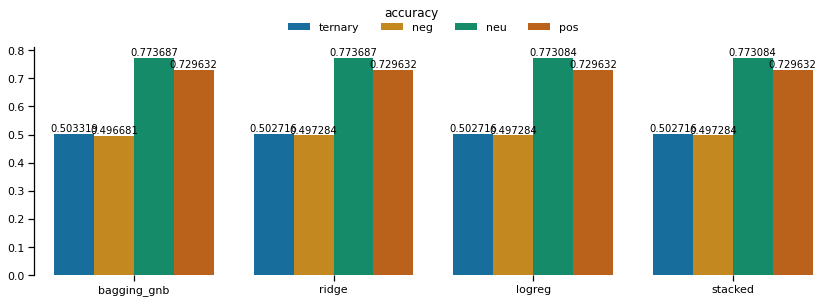

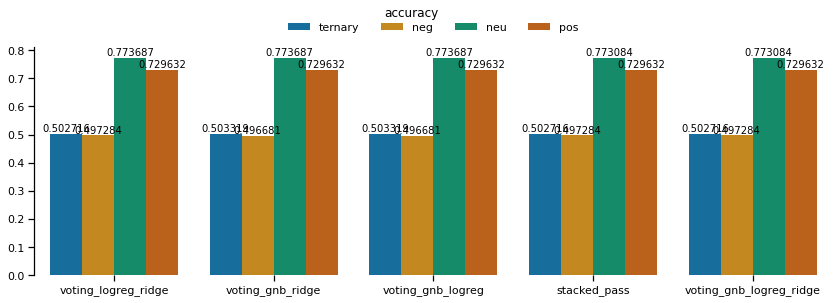

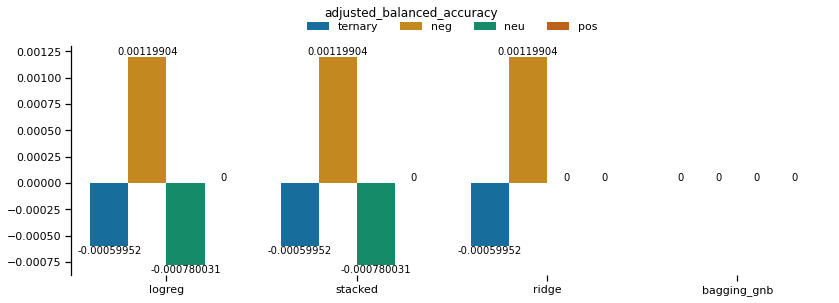

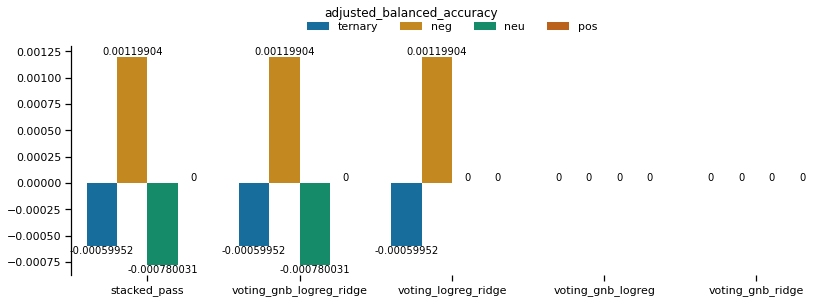

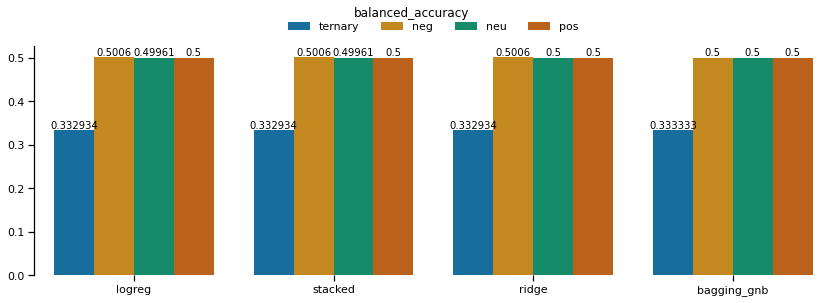

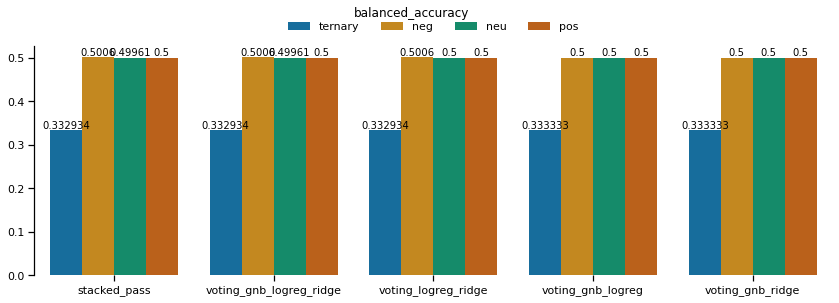

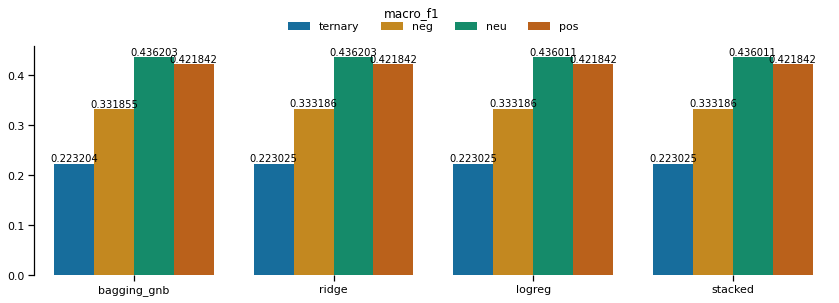

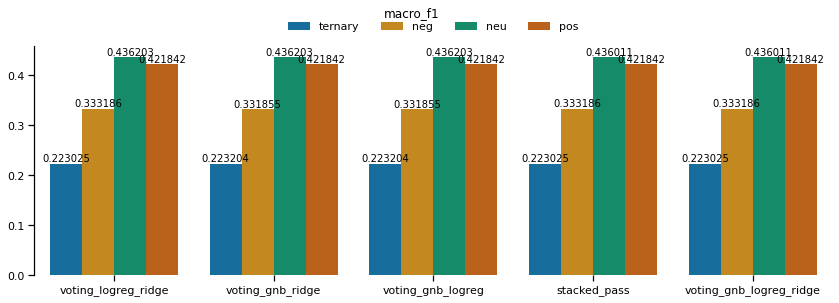

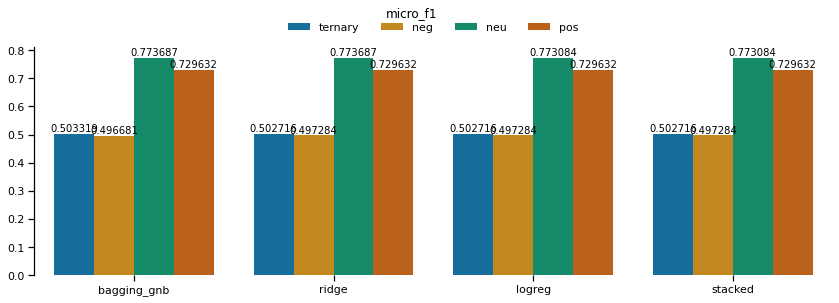

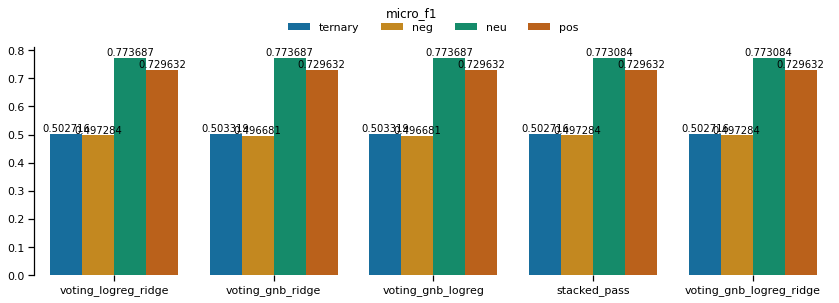

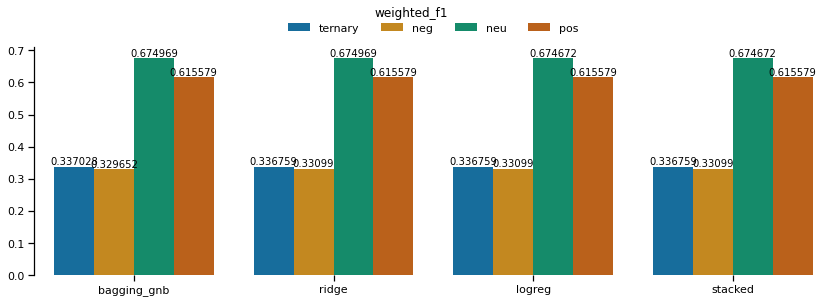

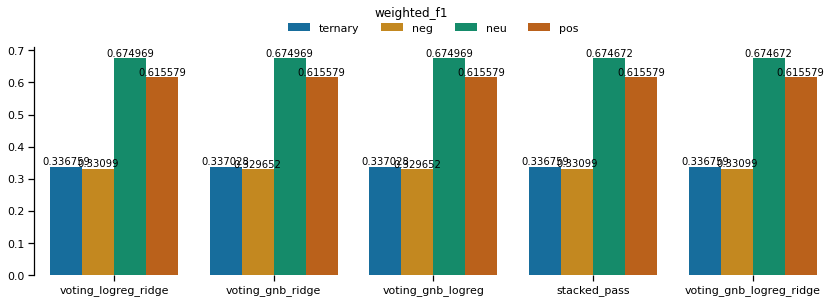

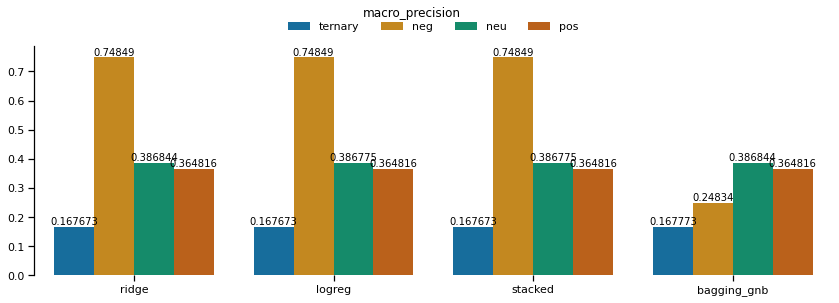

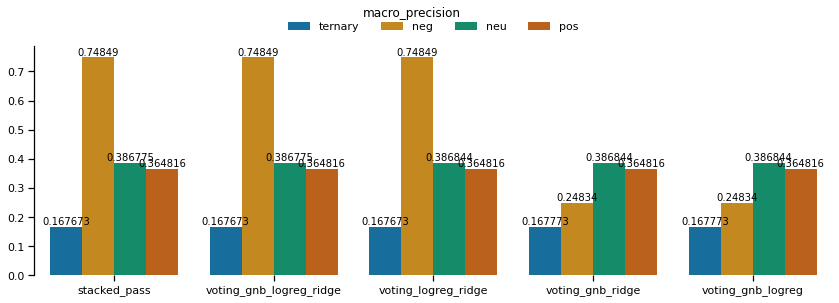

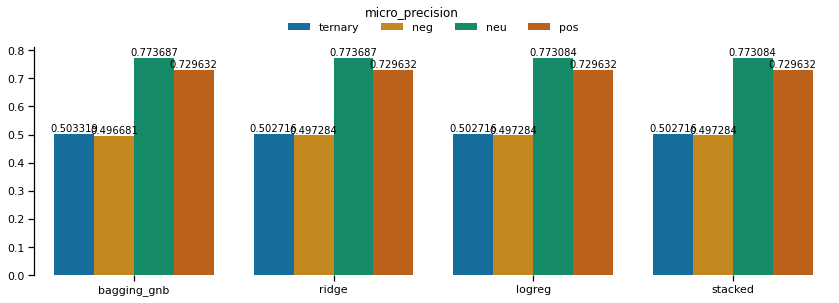

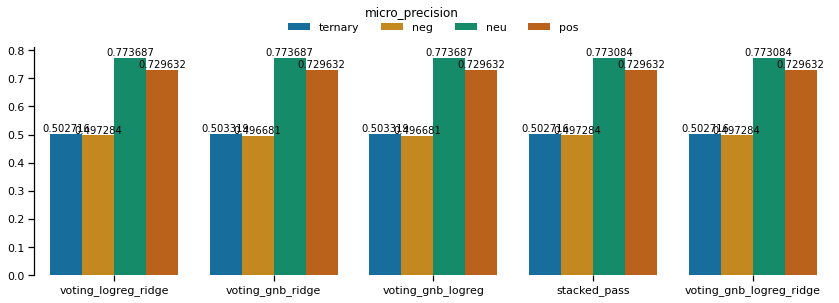

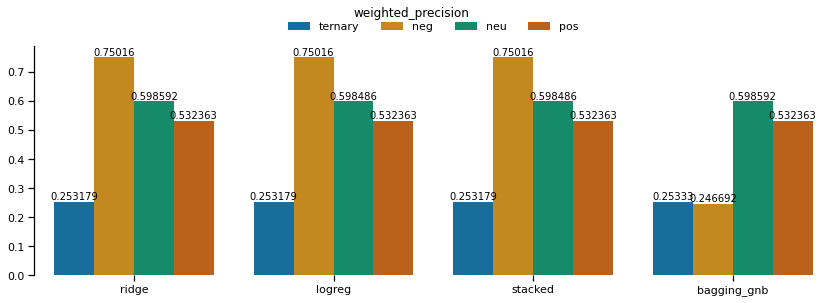

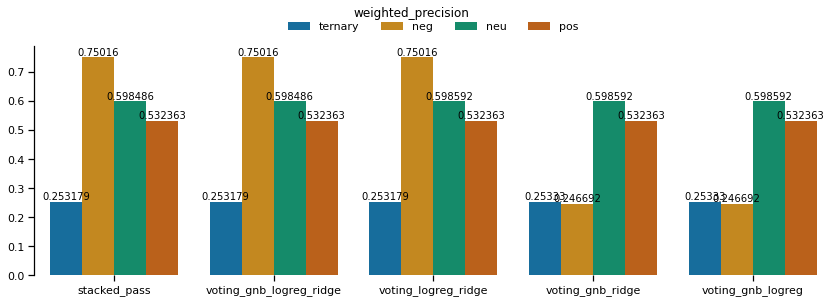

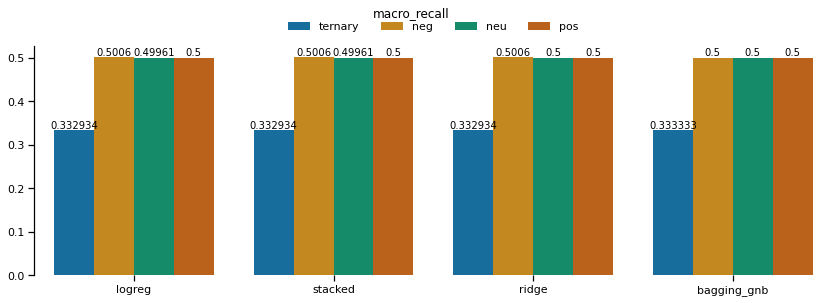

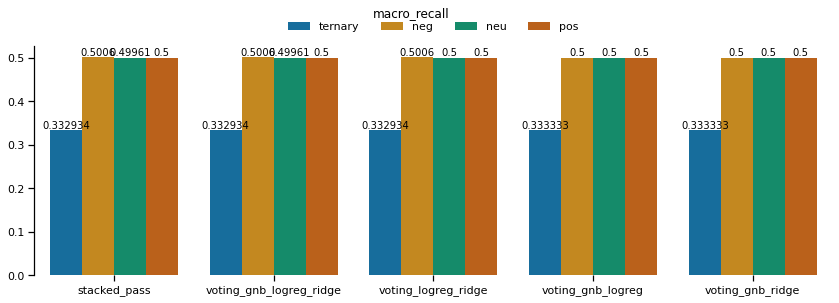

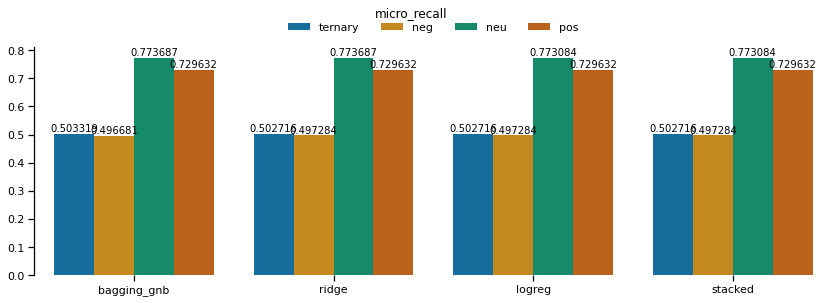

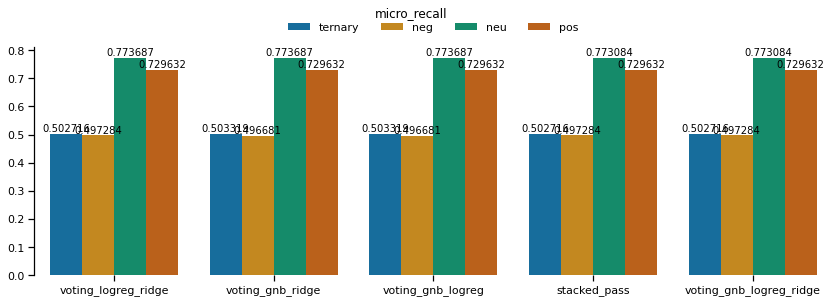

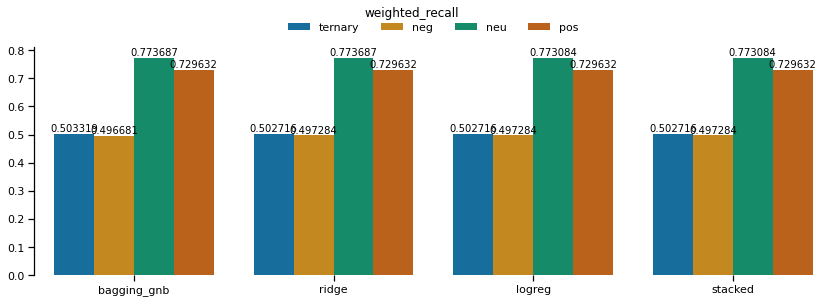

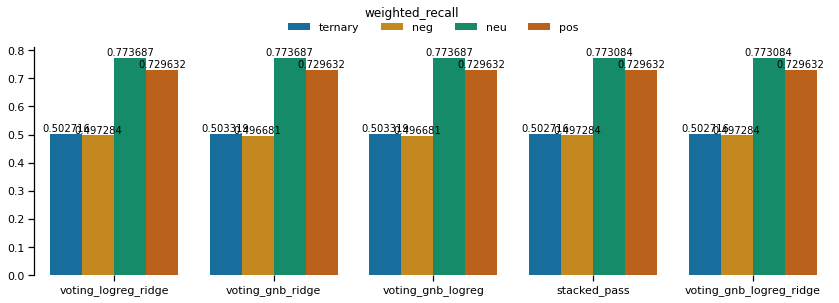

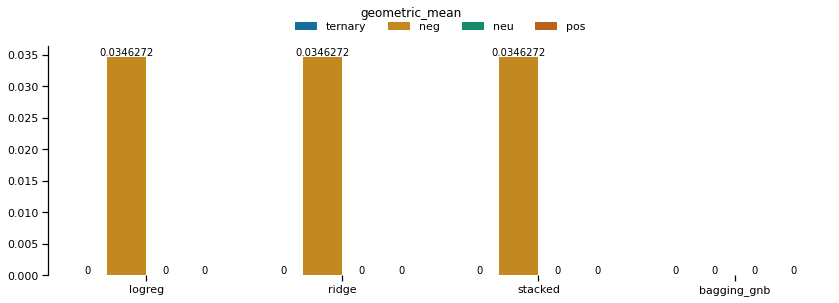

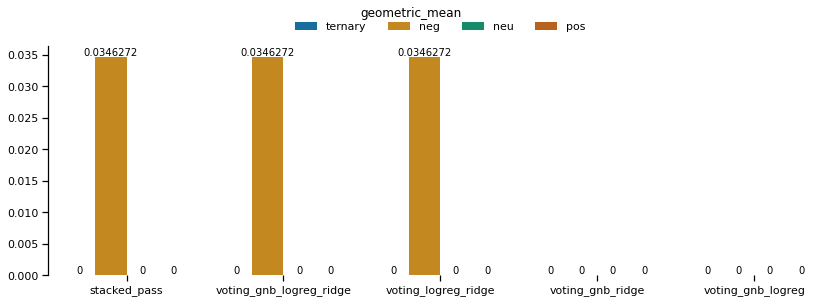

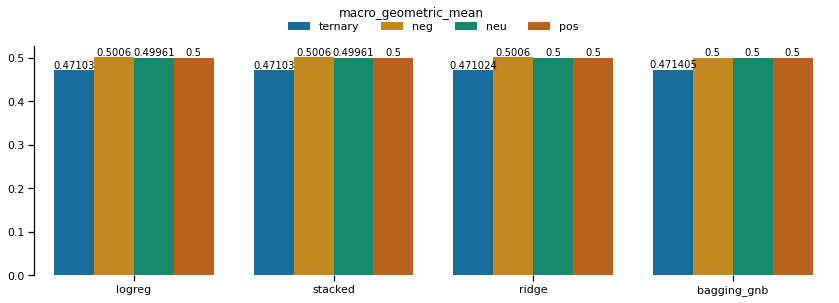

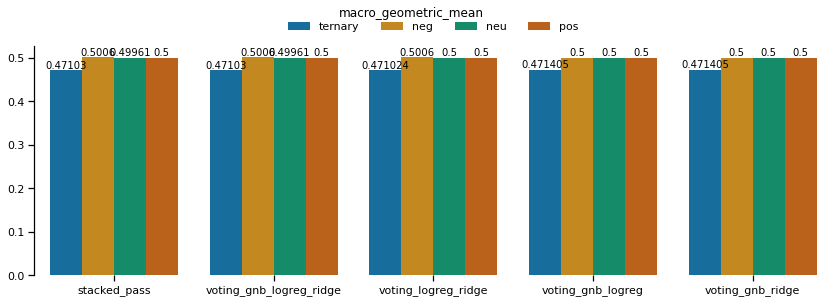

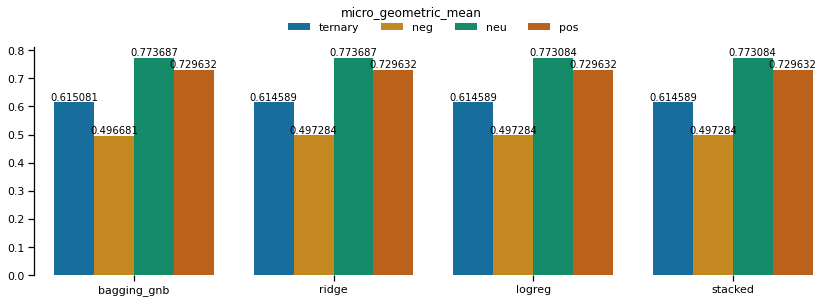

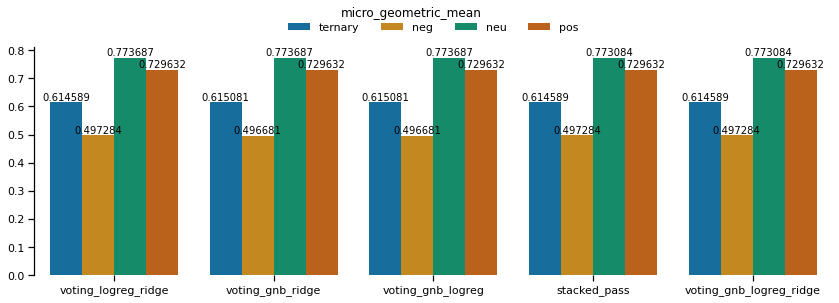

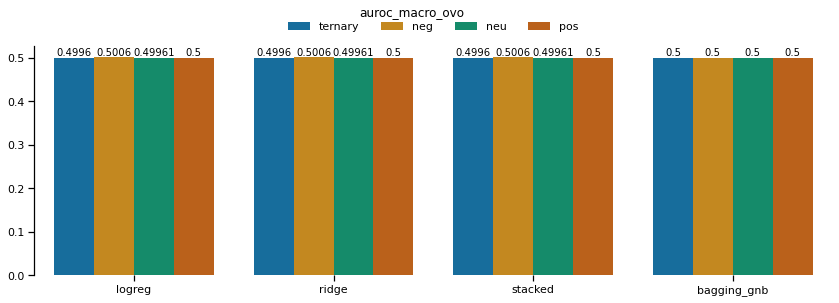

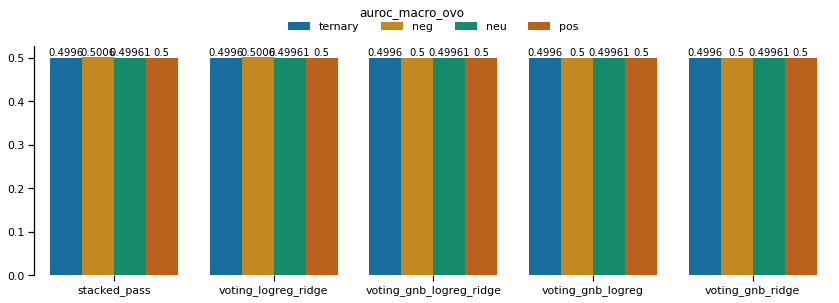

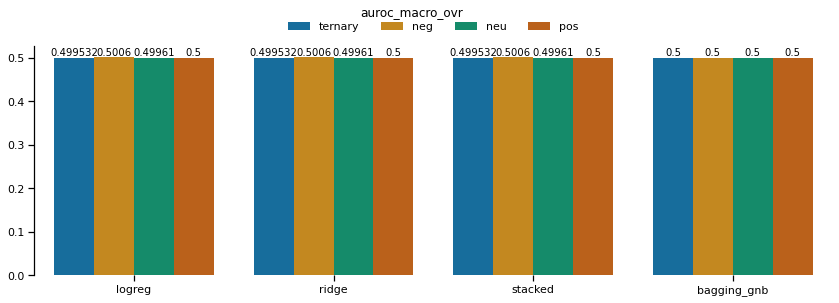

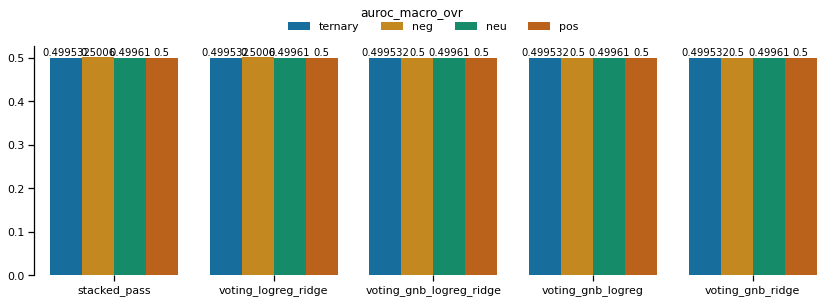

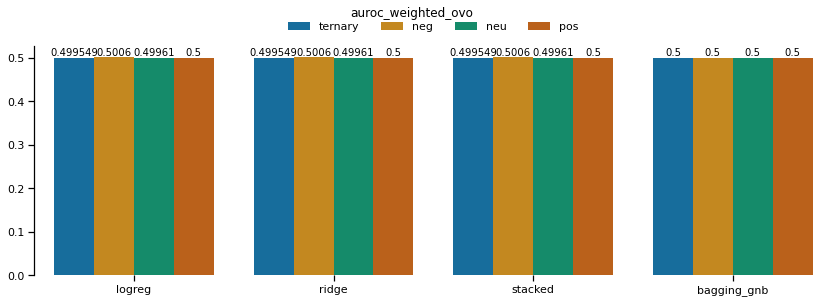

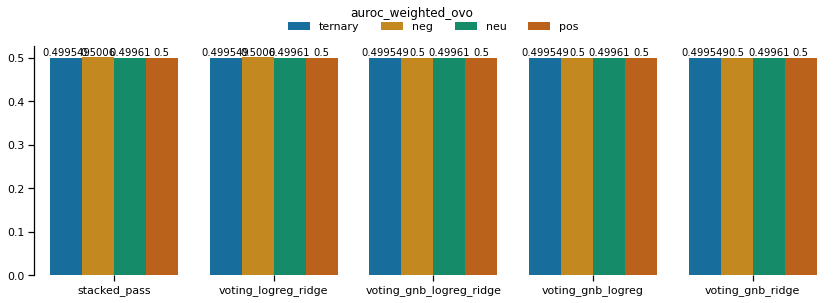

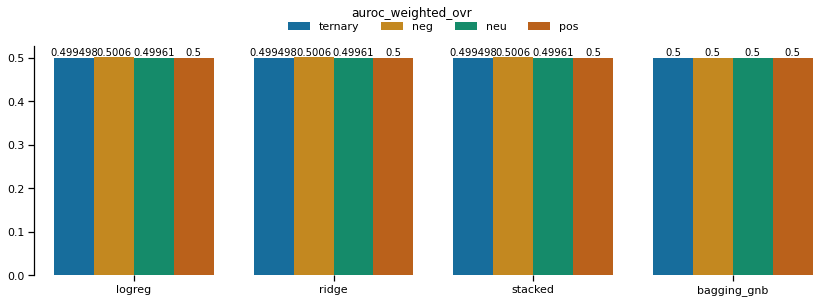

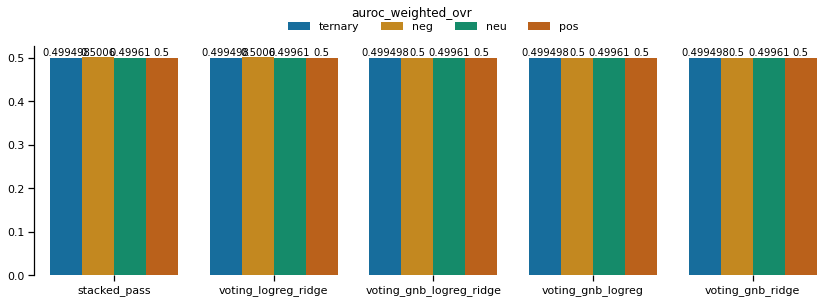

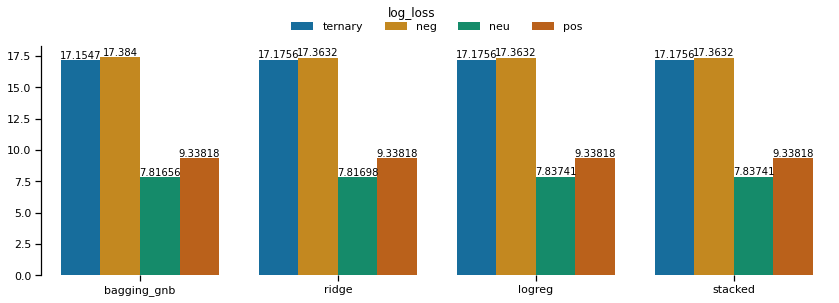

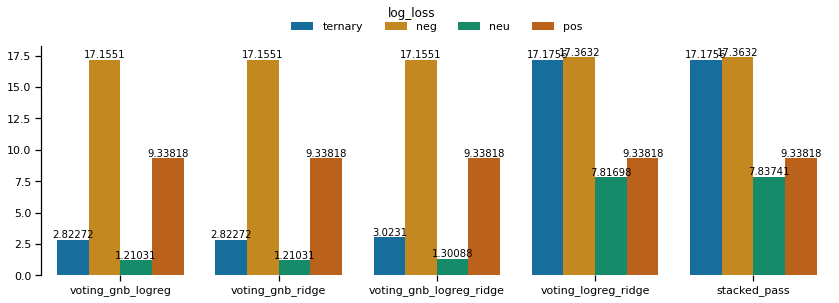

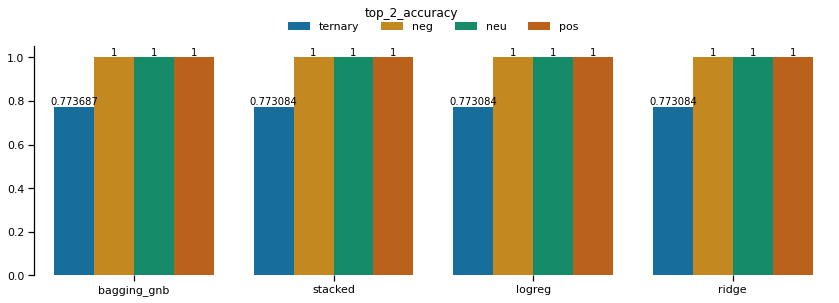

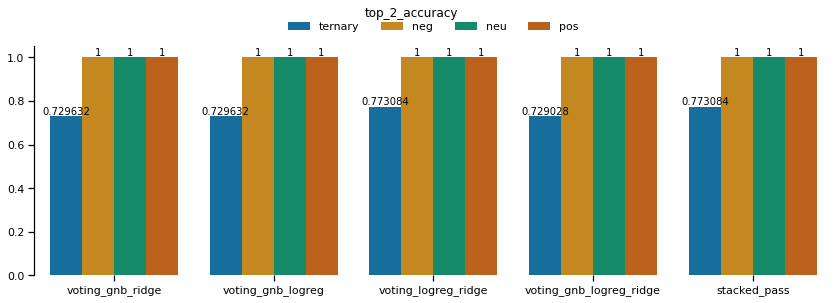

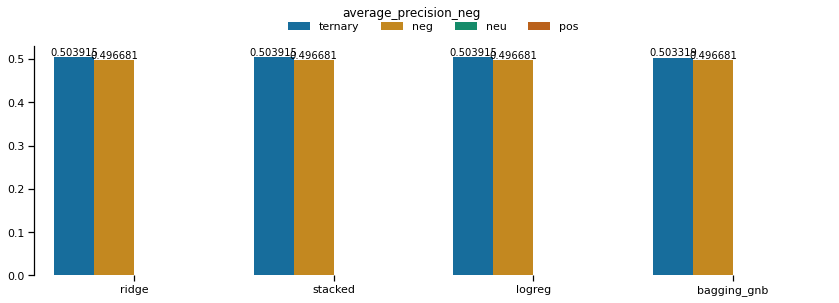

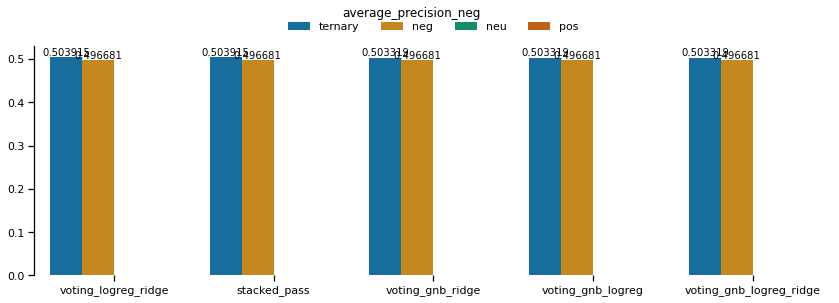

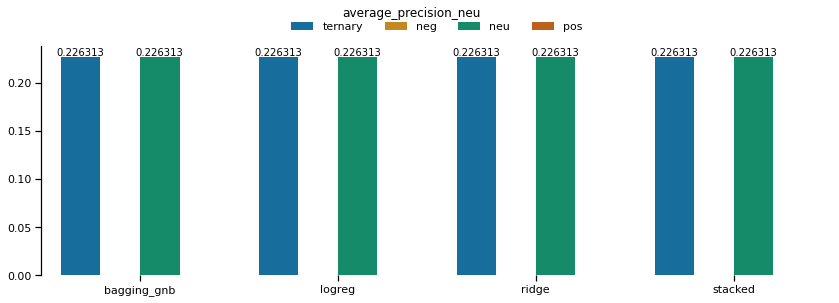

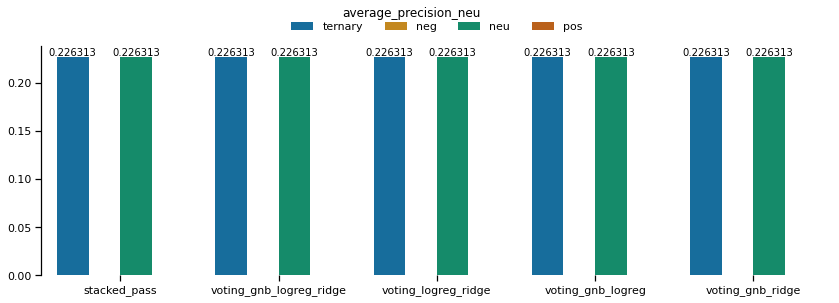

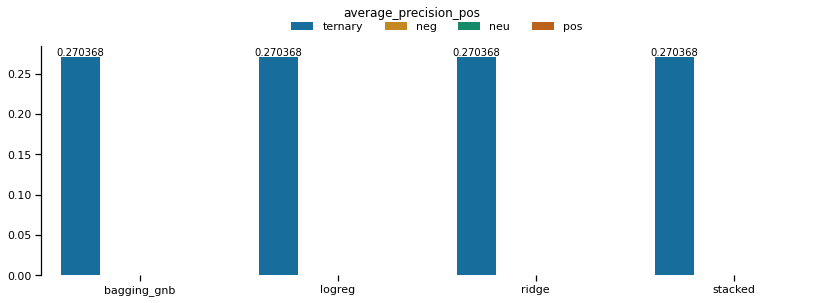

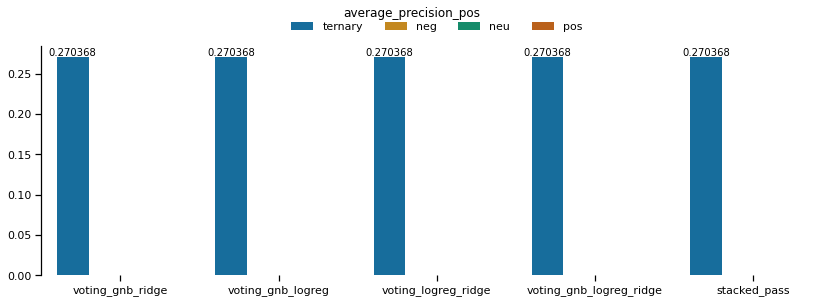

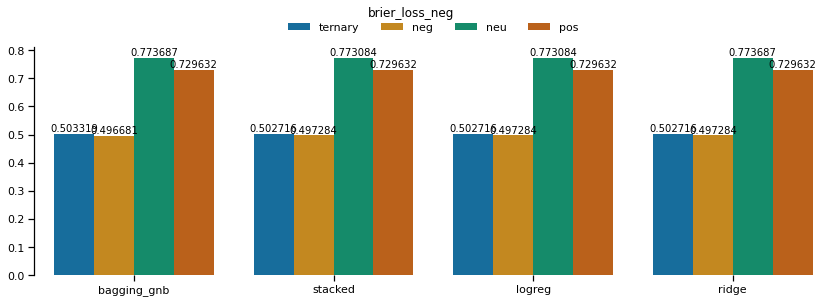

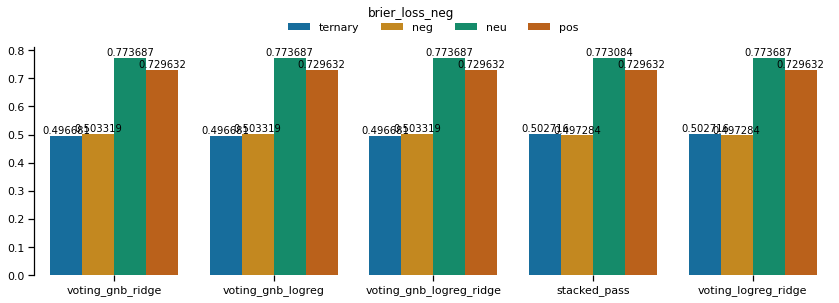

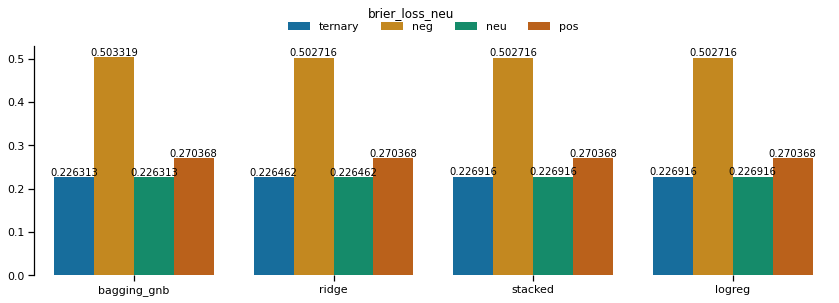

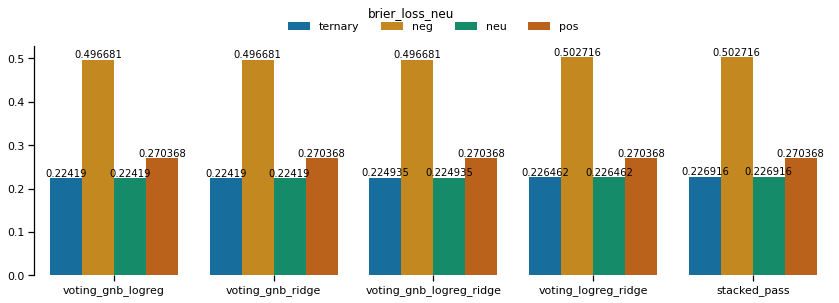

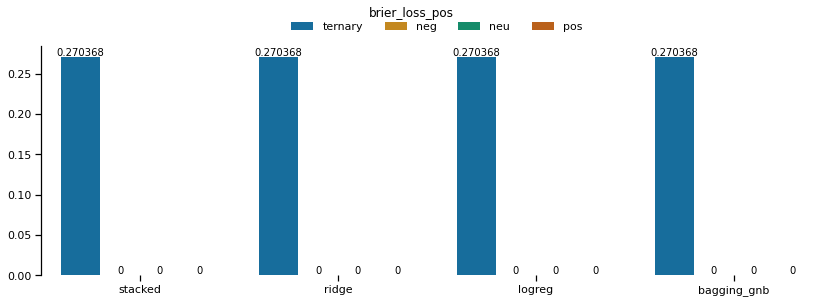

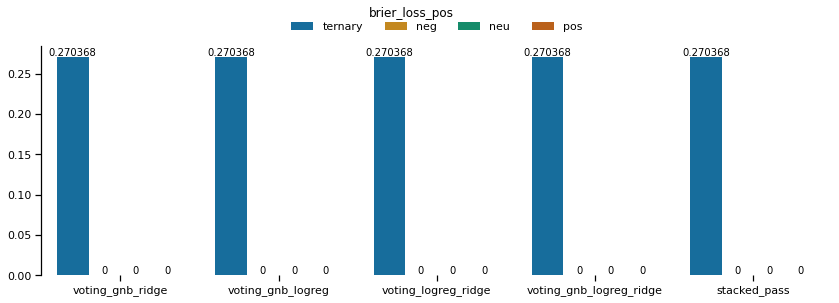

time: 24 s


In [15]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[
    results_df.score_set.isin({"ternary", "neg", "neu", "pos"}), :
]
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    df1 = df.loc[df.model.isin(models[: (_ := len(np.unique(df.model)) // 2)]), :]
    df2 = df.loc[df.model.isin(models[_:]), :]
    g = sns.catplot(
        x="model",
        y=metric,
        data=df1,
        kind="bar",
        hue="score_set",
        hue_order=["ternary", "neg", "neu", "pos"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=3,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    _ = plt.legend(
        bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=4, frameon=False
    )
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()

    g = sns.catplot(
        x="model",
        y=metric,
        data=df2,
        kind="bar",
        hue="score_set",
        hue_order=["ternary", "neg", "neu", "pos"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=3,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    _ = plt.legend(
        bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=4, frameon=False
    )
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()

    del df
    del df1
    del df2
    del g
    del ax
    _ = gc_collect()

# One English sample

This is a positive sample, so 2 would be a correct prediction.

In [16]:
df_ = data.loc[labels.lang1 == "eng", :]
for model in MODELS:
    df = df_
    if "GNB" in model:
        df = df_.loc[:, GNB_FEATURES]
    print(f"{model} predicted {load_model(model).predict(df)}")
del df
_ = gc_collect()
# correct prediction is 2

bagging_gnb predicted [0]
logreg predicted [0]
ridge predicted [0]
voting_gnb_ridge predicted [0]
voting_gnb_logreg predicted [0]
voting_logreg_ridge predicted [0]
voting_gnb_logreg_ridge predicted [0]
stacked_pass predicted [0]
stacked predicted [0]
time: 2.06 s


None of them could get it. :(

In [18]:
results_df = pd.DataFrame(results)
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{OUT_FOLDER}/holdout_results.csv")
_ = gc_collect()

time: 192 ms


<AxesSubplot:xlabel='model'>

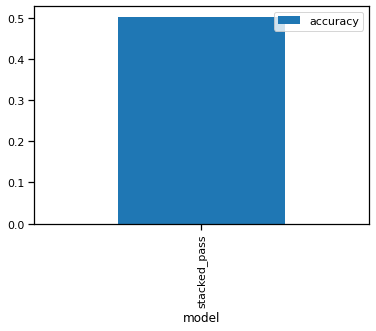

<AxesSubplot:xlabel='model'>

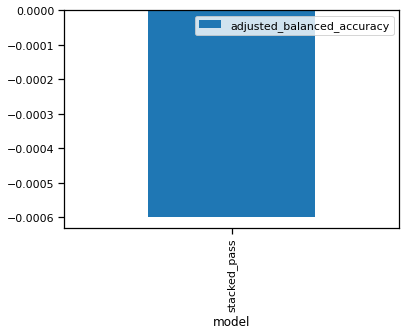

<AxesSubplot:xlabel='model'>

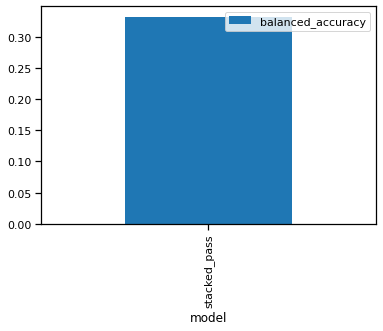

<AxesSubplot:xlabel='model'>

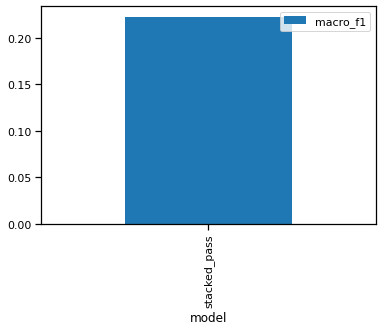

<AxesSubplot:xlabel='model'>

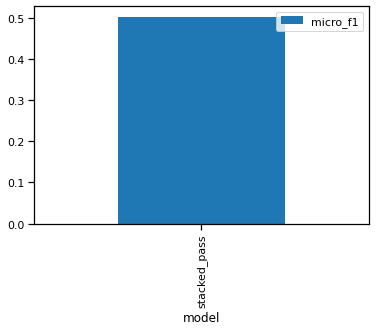

<AxesSubplot:xlabel='model'>

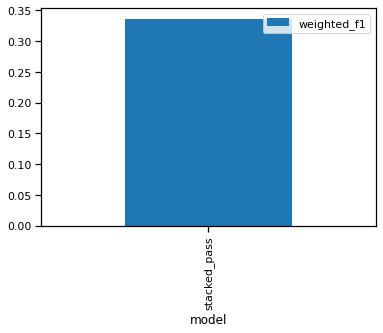

<AxesSubplot:xlabel='model'>

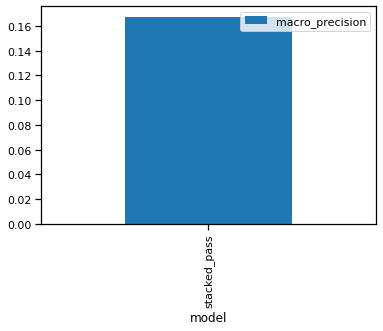

<AxesSubplot:xlabel='model'>

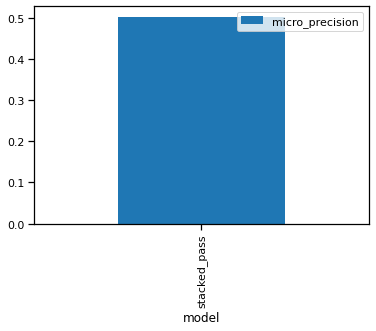

<AxesSubplot:xlabel='model'>

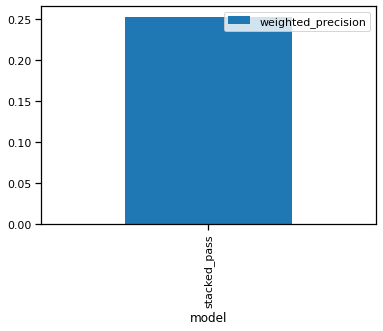

<AxesSubplot:xlabel='model'>

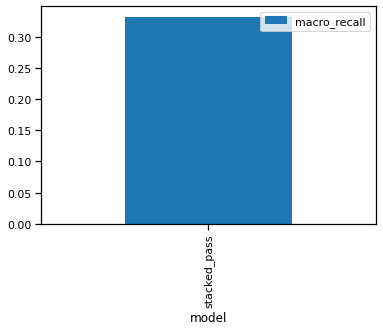

<AxesSubplot:xlabel='model'>

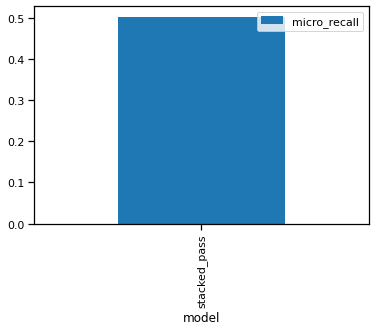

<AxesSubplot:xlabel='model'>

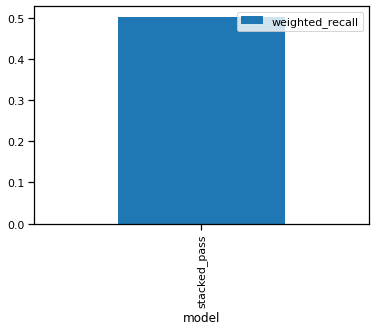

<AxesSubplot:xlabel='model'>

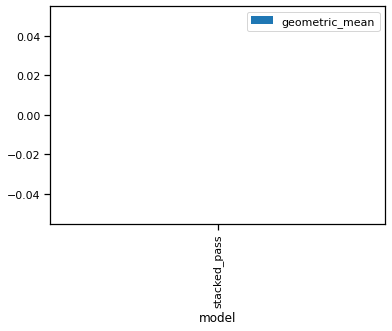

<AxesSubplot:xlabel='model'>

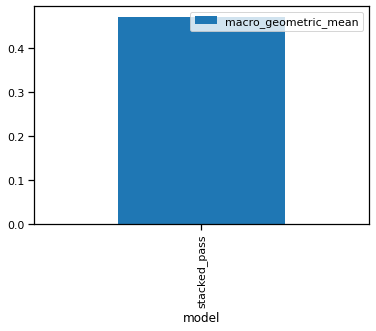

<AxesSubplot:xlabel='model'>

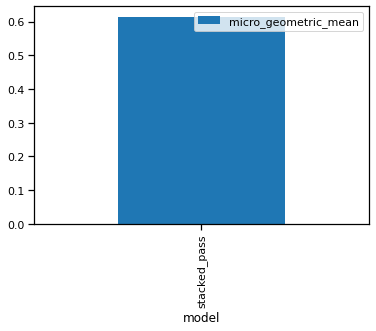

<AxesSubplot:xlabel='model'>

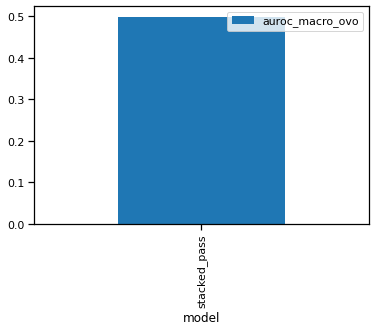

<AxesSubplot:xlabel='model'>

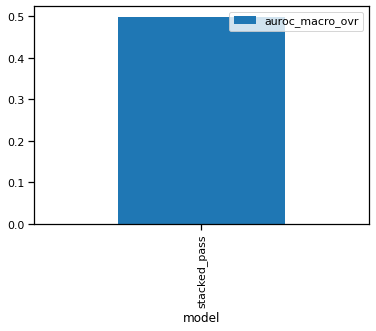

<AxesSubplot:xlabel='model'>

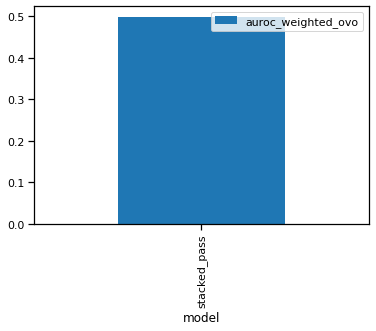

<AxesSubplot:xlabel='model'>

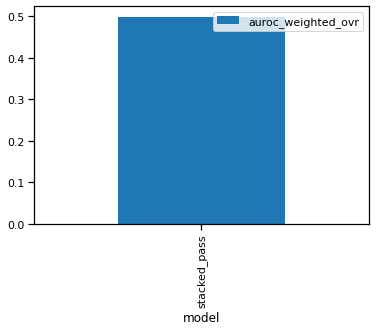

<AxesSubplot:xlabel='model'>

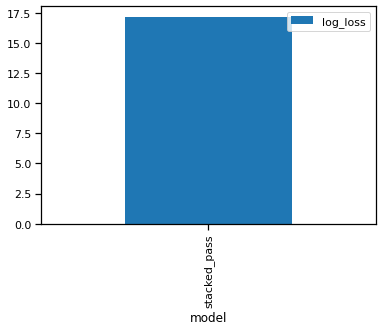

<AxesSubplot:xlabel='model'>

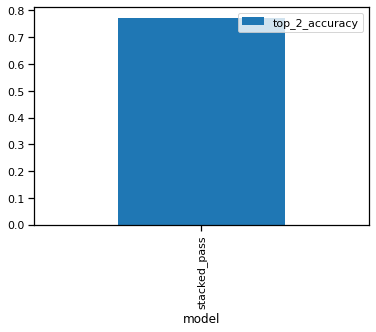

<AxesSubplot:xlabel='model'>

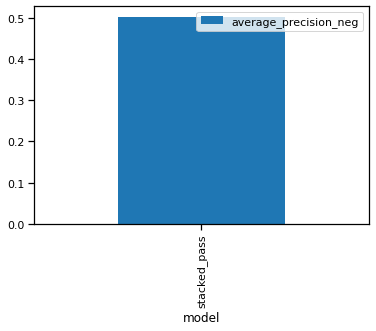

<AxesSubplot:xlabel='model'>

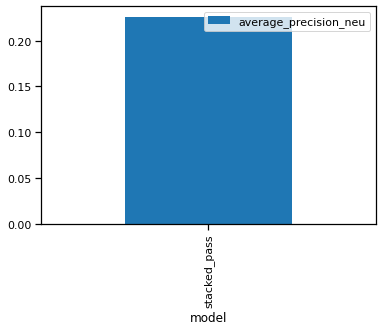

<AxesSubplot:xlabel='model'>

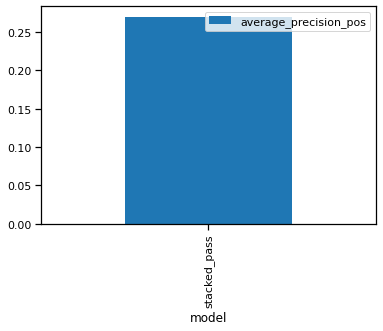

<AxesSubplot:xlabel='model'>

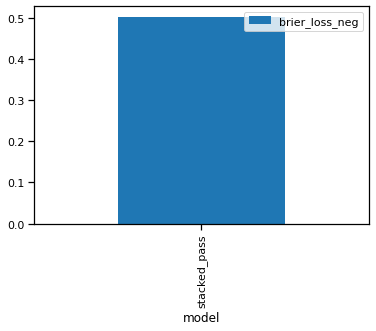

<AxesSubplot:xlabel='model'>

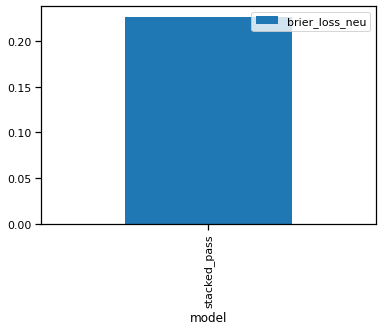

<AxesSubplot:xlabel='model'>

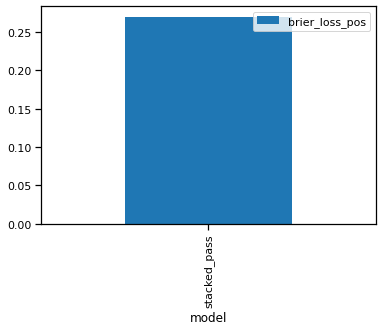

time: 3.82 s


In [19]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df.score_set == "ternary"]
results_df = results_df.loc[
    results_df.model.isin({"stacked_pass", "voting_gnbfull_logreg2f"}), :
]
for metric in METRICS:
    results_df.sort_values(by=metric, ascending="loss" in metric).plot(
        x="model", y=metric, kind="bar"
    )
    plt.show()

# Discussion

Goodness, these scores are horrible. I bet the feature extraction is fast, but this is unusable.

* best AUROC: 63.6% (ridge)
* best accuracy: 53.5% (voting ensemble of GNBfull and LogReg)
* best log loss: 1.058 (bagging_GNB on full features)

I'll probably use the stacked ensemble of a bagging GNB and ridge classifier (uncalibrated) with passthrough to a LogisticRegressionCV as final estimator. Or the voting ensemble of a bagged gnb on full features and a logisticregression on the top two features.

* stackedpass
  * accuracy: 48.4%
  * auroc: 63.1%
  * log loss: 1.1689
* voting gnbfull logreg2f
  * accuracy: 53.5%
  * auroc: 62.4%
  * log loss: 1.1098

We need to resist the temptation to revisit model development/selection. But if I were to go back, one of the first things to try would be to include a random forest in the stacked passthrough ensemble.

I imagine this is about as good as scores will get with the current approaches. I still think we could get a couple more points by training customized binary classifiers. There was evidence early on to suggest that one algorithm may not be optimal for all valences. Nonetheless, we can only get as good as the FRILL embeddings without upstream featurization or augmentation or significantly novel approaches like deep learning, which we've only tried a little.

In [ ]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

[^top](#Contents)

In [ ]:
sns.displot(x="valence", data=labels)
len(labels.loc[labels.valence == 0]) / len(labels)